In [1]:
DF_DOMINANT_TOPIC_PATH = "/Users/gunardiali/Documents/Master_Data_Science/Semester_1/NLP_StackOverflow/Project_StackOverflow/other/model_2012-2021_1/index/df_dominant_topic.pickle"

In [2]:
import pickle
import xlwings as xw
import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
def load_from_pickle(file_path):
    with open(file_path, "rb") as r:
        content = pickle.load(r)
    # print("Content from pickle: {}".format(content))
    return content

In [4]:
a = load_from_pickle(DF_DOMINANT_TOPIC_PATH)

In [5]:
a.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0     14106673               2              0.8414   
1     14106473               1              0.3375   
2     14106255               1              0.6833   
3     14106230               3              0.5757   
4     14106160               1              0.8331   

                                            Keywords  \
0  docker, run, java, error, spring, file, contai...   
1  class, variable, value, data, function, model,...   
2  class, variable, value, data, function, model,...   
3  token, spring, user, login, api, request, secu...   
4  class, variable, value, data, function, model,...   

                                                Text  
0  Reset File Permissions for Jekyll\nI accidenta...  
1  PHP SMTP Script "Failed to Initiate Authentica...  
2  optimize python processing json retrieved from...  
3  Getting an error implementing Roles in MVC 4\n...  
4  How can I map a List which contains entities o...

In [6]:
a_sorted = a.sort_values(by="Topic_Perc_Contrib", ascending=False)
a_sorted.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
36667      15907809               1              0.9408   
99729      28501791               1              0.9391   
42940      14168002               1              0.9374   
155304     43268166               2              0.9345   
262823     65649500               1              0.9339   

                                                 Keywords  \
36667   class, variable, value, data, function, model,...   
99729   class, variable, value, data, function, model,...   
42940   class, variable, value, data, function, model,...   
155304  docker, run, java, error, spring, file, contai...   
262823  class, variable, value, data, function, model,...   

                                                     Text  
36667   What could be causing an NRE when closing a fo...  
99729   Discovering the best approach to storing a spe...  
42940   Keep a TypedReference alive out of method bloc...  
155304  Cannot run SpringMVC/Hibernate CRUD on localho...  
262823  C# Cascading Derived Classes with Derived Prop...

In [7]:
#xw.view(a_sorted.loc[:1000, ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib']])

In [8]:
#xw.view(a_sorted.loc[:200, ['Dominant_Topic', 'Keywords']])

In [9]:
a_sorted = a_sorted.drop(['Keywords', 'Text'], axis=1)
a_sorted.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib
36667      15907809               1              0.9408
99729      28501791               1              0.9391
42940      14168002               1              0.9374
155304     43268166               2              0.9345
262823     65649500               1              0.9339

In [10]:
import sqlite3
from xmlrpc.client import Boolean
import pandas as pd
class SqliteOperation(object):
    """Generic class for basic SQLite Operations."""
    def __init__(self, path:str, batchsize:int=50):
        self.path = path
        self._connect = sqlite3.connect(path)
        self._cur = self._connect.cursor()
        self._connect.row_factory = sqlite3.Row
        self.batchsize = batchsize
        self.last_cursor = self._cur # Needed to query DB batchwise
        
    def execute_query(self, query:str, values:list=None, commit_=True) -> None:
        try:
            if values == None:
                self._cur.execute(query)
            else:
                self._cur.execute(query, values)
            if commit_:
                self._connect.commit()
                # print("*** Query commited successfully.")
        except sqlite3.Error as e:
            print(f"*** The error '{e}' occurred.")
        return
    
    def commit(self):
        self._connect.commit()
        return
    
    def close_conn(self):
        self._cur.close()
        self._connect.close()
        return
    
    def reopen_cursor(self):
        self.close_conn()
        self._connect = sqlite3.connect(self.path)
        self._cur = self._connect.cursor()
        return
    
    def create_table(self, name:str, schema:list) -> None:
        combined_schema = ", ".join(schema)
        create_table_query = """
        CREATE TABLE IF NOT EXISTS {}({})
        """.format(name, combined_schema)
        self.execute_query(create_table_query)
        return
    
    def convert_schema_to_label(self, schema:list) -> list:
        label_list = []
        for i in schema:
            # Extract only column name & insert to a list
            label_list.append((i.split()[0]))
        return label_list
    
    def insert_table(self, name:str, label:list, values_to_insert:list, commit_=True) -> None:
        total_columns = len(label)
        # Create necessary strings for SQLite query
        combined_label = ", ".join(label)
        string_for_values = ",".join(['?' for i in range(total_columns)])
        insert_table_query = """
        INSERT INTO {} ({})
        VALUES ({})
        """.format(name, combined_label, string_for_values)
        self.execute_query(insert_table_query, values_to_insert, commit_)
        return
    
    def repair_df_format(self, df_to_insert:pd.DataFrame) -> pd.DataFrame:
        label = list(df_to_insert.columns)
        #1 Repair date columns have correct format:
        # Necessary because SQLite doesn't have a datetime datatype
        # The next line looks for any label with date string
        datelabel_index = [i for i, s in enumerate(list(df_to_insert.columns)) if 'date' in s]
        for i in datelabel_index:
            current_label = label[i]
            df_to_insert[current_label] = df_to_insert[current_label].astype('str')
        return df_to_insert
        
    def insert_table_from_df(self, name, df_to_insert:pd.DataFrame) -> None:
        # Wraper for insert_table method for dataframe input.
        count = 0
        commit_ = False
        df_to_insert = self.repair_df_format(df_to_insert)
        label = list(df_to_insert.columns)
        for i in df_to_insert.itertuples(index=False):
            self.insert_table(name, label, list(i), commit_)
            # Divide and conquer commiting:
            count += 1
            if count == 100:
                commit_, count = True, 0
            else:
                commit_ = False
        self._connect.commit()
        # print("*** Query commited successfully.")
        return
    
    def add_new_column(self, table_name:str, new_column_name:str, \
        new_column_format:str) -> None:
        base = "ALTER TABLE {} ADD {} {}"
        return base.format(table_name, new_column_name, new_column_format)
    
    def update_column(self, table_name, column_name, where_column, column_value, \
        where_value):
        #UPDATE preprocessed_datas SET preprocessed_html = NULL WHERE id = 71367783
        base = """UPDATE {} SET {} = "{}" WHERE {} = {}"""
        query = base.format(table_name, column_name, column_value, where_column, \
            where_value)
        self.execute_query(query, commit_=False)
        return
    
    def generate_query_to_read_db(self, name:str, select_attr:str="*", \
        where_attr:str=None, like_attr:str=None, order_attr:str=None, \
        descending:Boolean=True, limit:int=None, offset:int=None) -> str:
        """Generate query to read from SQLite."""
        base = r'SELECT {} FROM {}'
        base = base.format(select_attr, name)
        if where_attr != None:
            where_base = r'WHERE {} LIKE {}'
            where_base = where_base.format(where_attr, like_attr)
            base = " ".join([base, where_base])
        if order_attr != None:
            order_base = r'ORDER BY {} {}'
            if descending:
                direction_str = "DESC"
            else:
                direction_str = "ASC"
            order_base.format(order_attr, direction_str)
            base = " ".join([base, order_base])
        if limit != None:
            limit_str = r'LIMIT {}'.format(str(limit))
            base = " ".join([base, limit_str])
        if offset != None:
            offset_str = r'OFFSET {}'.format(str(offset))
            base = " ".join([base, offset_str])
        return base
    
    def read_from_db(self, name:str, select_attr:str="*", \
        where_attr:str=None, like_attr:str=None, order_attr:str=None, \
        descending:Boolean=True, limit:int=None, offset:int=None) -> sqlite3.Cursor:
        """This function reads table from a DB and returns an itterable.
        It uses "generate_query_to_read_db" to generate the necessary query.
        """
        query_str = self.generate_query_to_read_db(name, select_attr, \
            where_attr, like_attr, order_attr, descending, limit, offset)
        self.execute_query(query_str)
        for result in iter(self._cur.fetchone, None):
            yield result
    
    def get_rowcount_from_db(self, name:str) -> int:
        """Get total row count of a table. Useful when querying using offset."""
        rowcount_itter = self.read_from_db(name, "COUNT(*)")
        rowcount = next(rowcount_itter)[0]
        return rowcount
    
    def generate_query_batchread(self, name:str, select_attr:str="*", \
        where_attr:str=None, like_attr:str=None, order_attr:str=None, \
        descending:Boolean=True, limit:int=None, offset:int=None) -> list:
        """This function will generate a list consisting query string for 
        multiple batch sizes with OFFSET and save it in a list.
        Output: list of query string.
        Goal: querying the DB in a memory friendly way.
        How to use? Use self.execute_query(self.generate_query_batchread(...)).
        It becomes iterator and with for loop, each iteration can be called.
        """
        max_rowcount = self.get_rowcount_from_db(name)
        if offset == None:
            start_rowcount = 0
        else:
            start_rowcount = offset
            
        if limit == None:
            total_requested_rowcount = max_rowcount
        else:
            total_requested_rowcount = limit
        
        # Generate the size for different batches for LIMIT variable
        available_rowcount = total_requested_rowcount - start_rowcount
        fullrange_count = available_rowcount//self.batchsize
        lastrange_count = available_rowcount%self.batchsize
        batchsize_list = []
        for i in range(fullrange_count):
            batchsize_list.append(self.batchsize)
        batchsize_list.append(lastrange_count)

        # Generate the start position for different batches
        start_position_list = []
        temp_position = start_rowcount
        for i in range(fullrange_count+1):
            temp_position = start_rowcount + i*self.batchsize
            start_position_list.append(temp_position)
        
        # Generate query strings with different start_position, batch size and
        # save it in a list.
        batch_query_list = []
        for i in range(fullrange_count+1):
            start_position = start_position_list[i]
            batch_size = batchsize_list[i]
            query_str = self.generate_query_to_read_db(name, select_attr, \
                where_attr, like_attr, order_attr, descending, \
                batch_size, start_position)
            batch_query_list.append(query_str)
        return batch_query_list
        
if __name__ == "__main__":
    PATH_SQLITE = "/Users/gunardiali/Documents/Master_Data_Science/Semester_1/NLP_StackOverflow/Project_StackOverflow/DB/StackOverflow.sqlite"
    NAME_TABLE = "raw_datas"
    
    sqlite_handler = SqliteOperation(PATH_SQLITE, 3)
    itterable_row = sqlite_handler.read_from_db(NAME_TABLE, "id", limit=10)
    
    for i in itterable_row:
        print(i)

(71367783,)
(71367669,)
(71367358,)
(71367342,)
(71367079,)
(71367063,)
(71366764,)
(71366719,)
(71366590,)
(71366583,)


In [11]:
PATH_SQLITE = "/Users/gunardiali/Documents/Master_Data_Science/Semester_1/NLP_StackOverflow/Project_StackOverflow/DB/StackOverflow.sqlite"
NAME_TABLE = "raw_datas"

In [12]:
sqlite_handler = SqliteOperation(PATH_SQLITE, 50)

In [13]:
query = """
SELECT raw_datas.id, substr(raw_datas.creation_date, 1, 4) AS year, raw_datas.accepted_answer_id
FROM raw_datas
WHERE (substr(raw_datas.creation_date, 1, 4) BETWEEN '2012' AND '2021')
"""

In [14]:
sqlite_handler.execute_query(query)
df = pd.DataFrame(sqlite_handler.last_cursor, columns=["id", "creation_year", "accepted_answer"])
df.set_index("id", inplace=True)
df.head()

creation_year  accepted_answer
id                                     
70546292          2021              NaN
70546175          2021       70546238.0
70545784          2021              NaN
70545763          2021       70612718.0
70545585          2021       70561270.0

In [15]:
len(a_sorted), len(df), len(df)-len(a_sorted)

(263307, 264148, 841)

In [16]:
a_sorted.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib
36667      15907809               1              0.9408
99729      28501791               1              0.9391
42940      14168002               1              0.9374
155304     43268166               2              0.9345
262823     65649500               1              0.9339

In [17]:
a_sorted.rename(columns={"Document_No":"id"}, inplace=True)
a_sorted.set_index("id", inplace=True)
a_sorted.head()

Dominant_Topic  Topic_Perc_Contrib
id                                          
15907809               1              0.9408
28501791               1              0.9391
14168002               1              0.9374
43268166               2              0.9345
65649500               1              0.9339

In [18]:
b_df = df.join(a_sorted, on='id', how='right')
b_df.head()

creation_year  accepted_answer  Dominant_Topic  Topic_Perc_Contrib
id                                                                         
15907809          2013       15908298.0               1              0.9408
28501791          2015       28503088.0               1              0.9391
14168002          2013       14228125.0               1              0.9374
43268166          2017              NaN               2              0.9345
65649500          2021       67061576.0               1              0.9339

In [19]:
len(b_df)

263307

In [20]:
table = pd.pivot_table(b_df, values='accepted_answer', 
                       index=['creation_year', 'Dominant_Topic'], 
                       aggfunc=len)
table.rename(columns={"accepted_answer": 'total'}, inplace=True)
table.head(10)

total
creation_year Dominant_Topic       
2012          1                6640
              2                2361
              3                2039
              4                3072
              5                2036
              6                1626
2013          1                8572
              2                3686
              3                2814
              4                3353

In [21]:
table.loc['2012','total'].sum()

17774

In [22]:
b_df.loc[b_df['accepted_answer'].isna()]

creation_year  accepted_answer  Dominant_Topic  Topic_Perc_Contrib
id                                                                         
43268166          2017              NaN               2              0.9345
39191166          2016              NaN               2              0.9330
23481453          2014              NaN               1              0.9330
43236749          2017              NaN               2              0.9328
42603678          2017              NaN               2              0.9326
...                ...              ...             ...                 ...
50807403          2018              NaN               2              0.1667
24183325          2014              NaN               2              0.1667
67421407          2021              NaN               2              0.1667
40376812          2016              NaN               2              0.1667
23161385          2014              NaN               2              0.1667

[150926 rows x 4 columns]

In [23]:
na_df = b_df.loc[b_df['accepted_answer'].isna()]
table_na = pd.pivot_table(na_df, values='accepted_answer', 
                       index=['creation_year', 'Dominant_Topic'], 
                       aggfunc=len)
table_na.rename(columns={"accepted_answer": 'total_na'}, inplace=True)
table_na.head(10)

total_na
creation_year Dominant_Topic          
2012          1                   2292
              2                   1035
              3                    849
              4                   1381
              5                    792
              6                    670
2013          1                   3726
              2                   1903
              3                   1362
              4                   1787

In [24]:
summary_df = table.join(table_na)
summary_df.head()

total  total_na
creation_year Dominant_Topic                 
2012          1                6640      2292
              2                2361      1035
              3                2039       849
              4                3072      1381
              5                2036       792

In [25]:
summary_df['rel_na'] = ((summary_df['total_na']/summary_df['total'])*100)
summary_df.head()

total  total_na     rel_na
creation_year Dominant_Topic                            
2012          1                6640      2292  34.518072
              2                2361      1035  43.837357
              3                2039       849  41.638058
              4                3072      1381  44.954427
              5                2036       792  38.899804

In [26]:
#xw.view(summary_df)

In [27]:
topic_dict = {
    1: "General System Dev",
    2: "Android & Java Dev",
    3: "Cloud Access Management",
    4: "Server Architecture",
    5: "Mobile App Dev",
    6: "Website Dev"
}

In [28]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="rel_na", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Questions without Accepted Answer", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Relative Percentage",
                 xaxis_title="Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.show()

In [29]:
summary_df.head(10)

total  total_na     rel_na
creation_year Dominant_Topic                            
2012          1                6640      2292  34.518072
              2                2361      1035  43.837357
              3                2039       849  41.638058
              4                3072      1381  44.954427
              5                2036       792  38.899804
              6                1626       670  41.205412
2013          1                8572      3726  43.467102
              2                3686      1903  51.627781
              3                2814      1362  48.400853
              4                3353      1787  53.295556

In [30]:
summary_df.loc['2012', 'rel_na'].sum(0)#/6

245.0531298865585

In [31]:
summary_df.reset_index().groupby('creation_year')['rel_na'].sum()/6

creation_year
2012    40.842188
2013    49.026795
2014    53.048745
2015    56.380085
2016    58.506780
2017    60.492865
2018    61.417136
2019    62.278974
2020    63.648542
2021    72.501926
Name: rel_na, dtype: float64

In [32]:
summary_df['diff'] = summary_df['rel_na']-(summary_df.reset_index().groupby('creation_year')['rel_na'].sum()/6)
summary_df.head(10)

total  total_na     rel_na      diff
creation_year Dominant_Topic                                      
2012          1                6640      2292  34.518072 -6.324116
              2                2361      1035  43.837357  2.995169
              3                2039       849  41.638058  0.795870
              4                3072      1381  44.954427  4.112239
              5                2036       792  38.899804 -1.942385
              6                1626       670  41.205412  0.363224
2013          1                8572      3726  43.467102 -5.559693
              2                3686      1903  51.627781  2.600985
              3                2814      1362  48.400853 -0.625943
              4                3353      1787  53.295556  4.268761

In [33]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
#colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'] 
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="diff", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Questions without Accepted Answer", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Relative Percentage",
                 xaxis_title="Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.add_shape( # add a horizontal "target" line
    type="line", line_color="black", line_width=2, opacity=1,
    x0=0, x1=1, xref="paper", y0=0, y1=0, yref="y"
)
fig.show()

In [34]:
summary_df.head(7)

total  total_na     rel_na      diff
creation_year Dominant_Topic                                      
2012          1                6640      2292  34.518072 -6.324116
              2                2361      1035  43.837357  2.995169
              3                2039       849  41.638058  0.795870
              4                3072      1381  44.954427  4.112239
              5                2036       792  38.899804 -1.942385
              6                1626       670  41.205412  0.363224
2013          1                8572      3726  43.467102 -5.559693

In [35]:
summary_df.groupby('creation_year')['total'].sum()

creation_year
2012    17774
2013    25429
2014    28755
2015    31277
2016    31243
2017    29094
2018    26267
2019    23505
2020    25531
2021    24432
Name: total, dtype: int64

In [36]:
# summary_df['diff'] = summary_df['rel_na']-(summary_df.reset_index().groupby('creation_year')['rel_na'].sum()/6)
summary_df['rel_total_na'] = summary_df['total_na']/(summary_df.groupby('creation_year')['total'].sum())
summary_df.head()

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   

                              rel_total_na  
creation_year Dominant_Topic                
2012          1                   0.128952  
              2                   0.058231  
              3                   0.047766  
              4                   0.077698  
              5                   0.044559

In [37]:
summary_df.reset_index().groupby('creation_year')['rel_total_na'].sum()/6

creation_year
2012    0.065817
2013    0.079830
2014    0.086443
2015    0.092144
2016    0.096096
2017    0.099551
2018    0.101426
2019    0.102751
2020    0.105055
2021    0.119788
Name: rel_total_na, dtype: float64

In [38]:
summary_df['diff2'] = ((summary_df['rel_total_na']-
                        (summary_df.reset_index().groupby('creation_year')['rel_total_na'].sum()/6))*100).round(2)
summary_df.head(20)

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   
              6                1626       670  41.205412  0.363224   
2013          1                8572      3726  43.467102 -5.559693   
              2                3686      1903  51.627781  2.600985   
              3                2814      1362  48.400853 -0.625943   
              4                3353      1787  53.295556  4.268761   
              5                4596      2221  48.324630 -0.702165   
              6                2408      1181  49.044850  0.018055   
2014          1                8867      4144  46.735085 -6.313660   
              2                4789      2594  54.165797  1.117051   
              3                3560      1917  53.848315  0.799569   
              4                3487      1968  56.438199  3.389454   
              5                5453      2880  52.814964 -0.233781   
              6                2599      1411  54.290112  1.241366   
2015          1                9005      4483  49.783454 -6.596631   
              2                5595      3246  58.016086  1.636001   

                              rel_total_na  diff2  
creation_year Dominant_Topic                       
2012          1                   0.128952   6.31  
              2                   0.058231  -0.76  
              3                   0.047766  -1.81  
              4                   0.077698   1.19  
              5                   0.044559  -2.13  
              6                   0.037696  -2.81  
2013          1                   0.146526   6.67  
              2                   0.074836  -0.50  
              3                   0.053561  -2.63  
              4                   0.070274  -0.96  
              5                   0.087341   0.75  
              6                   0.046443  -3.34  
2014          1                   0.144114   5.77  
              2                   0.090210   0.38  
              3                   0.066667  -1.98  
              4                   0.068440  -1.80  
              5                   0.100156   1.37  
              6                   0.049070  -3.74  
2015          1                   0.143332   5.12  
              2                   0.103782   1.16

In [39]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
#colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'] 
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="diff2", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Questions without Accepted Answer", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Relative Percentage",
                 xaxis_title="Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.add_shape( # add a horizontal "target" line
    type="line", line_color="black", line_width=2, opacity=1,
    x0=0, x1=1, xref="paper", y0=0, y1=0, yref="y"
)
fig.show()

In [40]:
summary_df['rel_total'] = ((summary_df['total']/summary_df.reset_index().groupby('creation_year')['total']
                            .sum())*100).round(2)
summary_df.head(8)

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   
              6                1626       670  41.205412  0.363224   
2013          1                8572      3726  43.467102 -5.559693   
              2                3686      1903  51.627781  2.600985   

                              rel_total_na  diff2  rel_total  
creation_year Dominant_Topic                                  
2012          1                   0.128952   6.31      37.36  
              2                   0.058231  -0.76      13.28  
              3                   0.047766  -1.81      11.47  
              4                   0.077698   1.19      17.28  
              5                   0.044559  -2.13      11.45  
              6                   0.037696  -2.81       9.15  
2013          1                   0.146526   6.67      33.71  
              2                   0.074836  -0.50      14.50

In [41]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
#colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'] 
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="rel_total", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Questions", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Relative Percentage",
                 xaxis_title="Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
#fig.update_layout(yaxis={"dtick":1,"range":[0,17]})
fig.show()

In [42]:
summary_df.head(10)

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   
              6                1626       670  41.205412  0.363224   
2013          1                8572      3726  43.467102 -5.559693   
              2                3686      1903  51.627781  2.600985   
              3                2814      1362  48.400853 -0.625943   
              4                3353      1787  53.295556  4.268761   

                              rel_total_na  diff2  rel_total  
creation_year Dominant_Topic                                  
2012          1                   0.128952   6.31      37.36  
              2                   0.058231  -0.76      13.28  
              3                   0.047766  -1.81      11.47  
              4                   0.077698   1.19      17.28  
              5                   0.044559  -2.13      11.45  
              6                   0.037696  -2.81       9.15  
2013          1                   0.146526   6.67      33.71  
              2                   0.074836  -0.50      14.50  
              3                   0.053561  -2.63      11.07  
              4                   0.070274  -0.96      13.19

In [43]:
summary_df['rel_na_normalized'] = summary_df['rel_na'] - summary_df.loc['2012']['rel_na']
summary_df.head(10)

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   
              6                1626       670  41.205412  0.363224   
2013          1                8572      3726  43.467102 -5.559693   
              2                3686      1903  51.627781  2.600985   
              3                2814      1362  48.400853 -0.625943   
              4                3353      1787  53.295556  4.268761   

                              rel_total_na  diff2  rel_total  \
creation_year Dominant_Topic                                   
2012          1                   0.128952   6.31      37.36   
              2                   0.058231  -0.76      13.28   
              3                   0.047766  -1.81      11.47   
              4                   0.077698   1.19      17.28   
              5                   0.044559  -2.13      11.45   
              6                   0.037696  -2.81       9.15   
2013          1                   0.146526   6.67      33.71   
              2                   0.074836  -0.50      14.50   
              3                   0.053561  -2.63      11.07   
              4                   0.070274  -0.96      13.19   

                              rel_na_normalized  
creation_year Dominant_Topic                     
2012          1                        0.000000  
              2                        0.000000  
              3                        0.000000  
              4                        0.000000  
              5                        0.000000  
              6                        0.000000  
2013          1                        8.949030  
              2                        7.790424  
              3                        6.762795  
              4                        8.341129

In [44]:
summary_df.loc['2012']['rel_na']

Dominant_Topic
1    34.518072
2    43.837357
3    41.638058
4    44.954427
5    38.899804
6    41.205412
Name: rel_na, dtype: float64

In [45]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
#colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'] 
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="rel_na_normalized", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Questions without Accepted Answer (Normalized to 2012)", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Relative Percentage",
                 xaxis_title="Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(yaxis={"range":[0,35]})
fig.show()

In [46]:
#colors = ['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']
#colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'] 
colors = ['#d73027','#fc8d59','#fee090','#762a83','#91bfdb','#4575b4']
fig = px.line(summary_df.reset_index(), x="creation_year", y="total_na", color='Dominant_Topic',
             color_discrete_sequence=colors)
fig.update_layout(legend_traceorder="reversed")
newnames = {'1':'General System Dev', '2': 'Android & Java Dev', '3':'Cloud Access Management', 
            '4':'Server Architecture', '5':'Mobile App Dev', '6':'Website Dev'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_layout(title_text="Total Questions without Accepted Answer", title_x=0.5, title_y=0.95)
fig.update_layout(legend_title_text='Dominant Topic', yaxis_title="Total",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.show()

In [47]:
summary_df.head(10)

total  total_na     rel_na      diff  \
creation_year Dominant_Topic                                         
2012          1                6640      2292  34.518072 -6.324116   
              2                2361      1035  43.837357  2.995169   
              3                2039       849  41.638058  0.795870   
              4                3072      1381  44.954427  4.112239   
              5                2036       792  38.899804 -1.942385   
              6                1626       670  41.205412  0.363224   
2013          1                8572      3726  43.467102 -5.559693   
              2                3686      1903  51.627781  2.600985   
              3                2814      1362  48.400853 -0.625943   
              4                3353      1787  53.295556  4.268761   

                              rel_total_na  diff2  rel_total  \
creation_year Dominant_Topic                                   
2012          1                   0.128952   6.31      37.36   
              2                   0.058231  -0.76      13.28   
              3                   0.047766  -1.81      11.47   
              4                   0.077698   1.19      17.28   
              5                   0.044559  -2.13      11.45   
              6                   0.037696  -2.81       9.15   
2013          1                   0.146526   6.67      33.71   
              2                   0.074836  -0.50      14.50   
              3                   0.053561  -2.63      11.07   
              4                   0.070274  -0.96      13.19   

                              rel_na_normalized  
creation_year Dominant_Topic                     
2012          1                        0.000000  
              2                        0.000000  
              3                        0.000000  
              4                        0.000000  
              5                        0.000000  
              6                        0.000000  
2013          1                        8.949030  
              2                        7.790424  
              3                        6.762795  
              4                        8.341129

In [48]:
a_df = summary_df.groupby('creation_year')[['total','total_na']].sum()
a_df

total  total_na
creation_year                 
2012           17774      7019
2013           25429     12180
2014           28755     14914
2015           31277     17292
2016           31243     18014
2017           29094     17378
2018           26267     15985
2019           23505     14491
2020           25531     16093
2021           24432     17560

In [49]:
a_df['rel_na'] = (a_df['total_na']/a_df['total'])*100
a_df

total  total_na     rel_na
creation_year                            
2012           17774      7019  39.490267
2013           25429     12180  47.898069
2014           28755     14914  51.865762
2015           31277     17292  55.286632
2016           31243     18014  57.657715
2017           29094     17378  59.730529
2018           26267     15985  60.855827
2019           23505     14491  61.650713
2020           25531     16093  63.033175
2021           24432     17560  71.872954

In [50]:
query = """
SELECT raw_datas.id, substr(raw_datas.creation_date, 1, 4) AS year, raw_datas.accepted_answer_id, raw_datas.tags
FROM raw_datas
WHERE (substr(raw_datas.creation_date, 1, 4) BETWEEN '2012' AND '2021')
"""

In [51]:
sqlite_handler.execute_query(query)
df = pd.DataFrame(sqlite_handler.last_cursor, columns=["id", "creation_year", "accepted_answer", 'tags'])
df.set_index("id", inplace=True)
df.head()

creation_year  accepted_answer  \
id                                        
70546292          2021              NaN   
70546175          2021       70546238.0   
70545784          2021              NaN   
70545763          2021       70612718.0   
70545585          2021       70561270.0   

                                                   tags  
id                                                       
70546292            c#|xamarin.forms|xamarin.forms.maps  
70546175  java|spring-boot|docker|tomcat|docker-compose  
70545784                             nginx|nginx-config  
70545763                     java|jboss|modeshape|p6spy  
70545585              javascript|node.js|reactjs|jestjs

In [52]:
c_df = df.join(a_sorted, on='id', how='right')
c_df.head()

creation_year  accepted_answer  \
id                                        
15907809          2013       15908298.0   
28501791          2015       28503088.0   
14168002          2013       14228125.0   
43268166          2017              NaN   
65649500          2021       67061576.0   

                                                       tags  Dominant_Topic  \
id                                                                            
15907809  c#|compact-framework|windows-ce|nullreferencee...               1   
28501791                            php|database|oop|object               1   
14168002             c#|delegates|unsafe|ref|typedreference               1   
43268166                java|spring|hibernate|maven|tomcat7               2   
65649500      c#|generics|inheritance|polymorphism|children               1   

          Topic_Perc_Contrib  
id                            
15907809              0.9408  
28501791              0.9391  
14168002              0.9374  
43268166              0.9345  
65649500              0.9339

In [53]:
c_df.loc[:,'tags'] = np.array([x.strip('[]').split('|') for x in c_df.loc[:,'tags']], dtype=object)
c_df.head()

creation_year  accepted_answer  \
id                                        
15907809          2013       15908298.0   
28501791          2015       28503088.0   
14168002          2013       14228125.0   
43268166          2017              NaN   
65649500          2021       67061576.0   

                                                       tags  Dominant_Topic  \
id                                                                            
15907809  [c#, compact-framework, windows-ce, nullrefere...               1   
28501791                       [php, database, oop, object]               1   
14168002       [c#, delegates, unsafe, ref, typedreference]               1   
43268166          [java, spring, hibernate, maven, tomcat7]               2   
65649500  [c#, generics, inheritance, polymorphism, chil...               1   

          Topic_Perc_Contrib  
id                            
15907809              0.9408  
28501791              0.9391  
14168002              0.9374  
43268166              0.9345  
65649500              0.9339

In [54]:
#df.loc[df['column_name'] == some_value]
na_c_df = c_df.loc[(c_df.loc[:,'accepted_answer'].isna())]
na_c_df.head()

creation_year  accepted_answer  \
id                                        
43268166          2017              NaN   
39191166          2016              NaN   
23481453          2014              NaN   
43236749          2017              NaN   
42603678          2017              NaN   

                                               tags  Dominant_Topic  \
id                                                                    
43268166  [java, spring, hibernate, maven, tomcat7]               2   
39191166  [java, spring, hibernate, maven, pom.xml]               2   
23481453                  [c++, c++11, memoization]               1   
43236749                     [java, hibernate, jpa]               2   
42603678      [spring, spring-mvc, spring-data-jpa]               2   

          Topic_Perc_Contrib  
id                            
43268166              0.9345  
39191166              0.9330  
23481453              0.9330  
43236749              0.9328  
42603678              0.9326

In [55]:
from collections import defaultdict

In [56]:
# weighted average
label_dict = defaultdict(lambda: 0)
for list_i in na_c_df.loc[:,'tags']:
    len_i = len(list_i)
    for i in list_i:
        label_dict[i] += 1/len_i

In [57]:
iterables = [label_dict.keys(), [1, 2, 3, 4, 5, 6]]

index = pd.MultiIndex.from_product(iterables, names=["label", "topic"])

label_nan_df = pd.DataFrame(0, index=index, columns=np.arange(2012, 2022))

label_nan_df.head(20)

2012  2013  2014  2015  2016  2017  2018  2019  2020  2021
label     topic                                                            
java      1         0     0     0     0     0     0     0     0     0     0
          2         0     0     0     0     0     0     0     0     0     0
          3         0     0     0     0     0     0     0     0     0     0
          4         0     0     0     0     0     0     0     0     0     0
          5         0     0     0     0     0     0     0     0     0     0
          6         0     0     0     0     0     0     0     0     0     0
spring    1         0     0     0     0     0     0     0     0     0     0
          2         0     0     0     0     0     0     0     0     0     0
          3         0     0     0     0     0     0     0     0     0     0
          4         0     0     0     0     0     0     0     0     0     0
          5         0     0     0     0     0     0     0     0     0     0
          6         0     0     0     0     0     0     0     0     0     0
hibernate 1         0     0     0     0     0     0     0     0     0     0
          2         0     0     0     0     0     0     0     0     0     0
          3         0     0     0     0     0     0     0     0     0     0
          4         0     0     0     0     0     0     0     0     0     0
          5         0     0     0     0     0     0     0     0     0     0
          6         0     0     0     0     0     0     0     0     0     0
maven     1         0     0     0     0     0     0     0     0     0     0
          2         0     0     0     0     0     0     0     0     0     0

In [58]:
label_nan_df.loc[('maven', 1), 2012]

0

In [59]:
for index, row in na_c_df.iterrows():
    tags = row['tags']
    label_num = len(tags)
    current_topic = row['Dominant_Topic']
    current_year = row['creation_year']
    current_weight = 1/label_num
    
    for label in tags:
        label_nan_df.loc[(label, current_topic), int(current_year)] += current_weight        

In [60]:
label_nan_df.head()

2012        2013        2014        2015        2016  \
label topic                                                               
java  1      107.816667  197.966667  248.633333  276.500000  269.133333   
      2      104.183333  204.683333  317.716667  366.850000  349.450000   
      3       33.883333   60.400000  109.450000  153.550000  175.683333   
      4       30.300000   38.700000   50.383333   65.083333   76.800000   
      5       32.483333  125.616667  207.783333  230.300000  244.366667   

                   2017        2018        2019        2020        2021  
label topic                                                              
java  1      247.233333  214.383333  208.116667  200.950000  160.850000  
      2      369.366667  318.250000  262.333333  280.766667  301.733333  
      3      168.100000  164.850000  157.183333  171.650000  156.116667  
      4       66.000000   63.266667   62.866667   55.733333   65.733333  
      5      227.166667  159.816667  158.383333  141.266667  132.150000

In [61]:
label_nan_df.query('topic == 1')

2012        2013        2014        2015  \
label          topic                                                   
java           1      107.816667  197.966667  248.633333  276.500000   
spring         1       15.216667   27.933333   36.716667   40.166667   
hibernate      1        9.716667   13.566667   12.883333   18.083333   
maven          1        0.500000    2.266667    3.250000    4.533333   
tomcat7        1        0.200000    0.200000    0.950000    1.233333   
...                          ...         ...         ...         ...   
oracle-bi      1        0.000000    0.000000    0.000000    0.000000   
att            1        0.000000    0.000000    0.000000    0.000000   
gateone        1        0.000000    0.000000    0.000000    0.000000   
.app           1        0.000000    0.000000    0.000000    0.000000   
aws-glue-spark 1        0.000000    0.000000    0.000000    0.000000   

                            2016        2017        2018        2019  \
label          topic                                                   
java           1      269.133333  247.233333  214.383333  208.116667   
spring         1       50.133333   47.866667   32.100000   31.850000   
hibernate      1       20.783333   22.466667   11.150000   16.866667   
maven          1        5.050000    4.983333    1.816667    2.433333   
tomcat7        1        0.200000    0.250000    0.500000    0.750000   
...                          ...         ...         ...         ...   
oracle-bi      1        0.000000    0.000000    0.000000    0.000000   
att            1        0.000000    0.000000    0.000000    0.000000   
gateone        1        0.000000    0.000000    0.000000    0.000000   
.app           1        0.000000    0.000000    0.000000    0.000000   
aws-glue-spark 1        0.000000    0.000000    0.000000    0.000000   

                            2020        2021  
label          topic                          
java           1      200.950000  160.850000  
spring         1       36.500000   31.250000  
hibernate      1       11.666667   10.433333  
maven          1        3.166667    0.933333  
tomcat7        1        0.200000    0.000000  
...                          ...         ...  
oracle-bi      1        0.000000    0.000000  
att            1        0.000000    0.000000  
gateone        1        0.000000    0.000000  
.app           1        0.000000    0.000000  
aws-glue-spark 1        0.000000    0.250000  

[19925 rows x 10 columns]

In [62]:
label_nan_df.query('topic == 1').sort_values(by=[2012], ascending=False).reset_index('topic').drop('topic', axis=1)

2012        2013        2014        2015        2016  \
label                                                                           
c#                 132.616667  181.750000  220.833333  223.566667  231.150000   
java               107.816667  197.966667  248.633333  276.500000  269.133333   
php                100.916667  175.466667  204.966667  234.033333  218.783333   
asp.net             84.266667  113.300000   89.300000   87.883333   73.700000   
android             77.333333  167.866667  188.700000  209.266667  221.483333   
...                       ...         ...         ...         ...         ...   
oam                  0.000000    0.000000    0.000000    0.000000    0.000000   
compact-framework    0.000000    1.450000    0.000000    0.333333    0.000000   
padarn               0.000000    0.000000    0.000000    0.000000    0.000000   
android-alarms       0.000000    0.000000    0.000000    0.000000    0.000000   
aws-glue-spark       0.000000    0.000000    0.000000    0.000000    0.000000   

                         2017        2018        2019        2020        2021  
label                                                                          
c#                 202.833333  200.800000  177.666667  146.116667  157.116667  
java               247.233333  214.383333  208.116667  200.950000  160.850000  
php                177.533333  151.300000  132.833333   97.250000  107.766667  
asp.net             59.083333   44.033333   31.933333   23.383333   25.333333  
android            188.850000  153.900000  120.133333   77.883333   66.816667  
...                       ...         ...         ...         ...         ...  
oam                  0.000000    0.000000    0.000000    0.000000    0.000000  
compact-framework    0.000000    0.200000    0.200000    0.000000    0.000000  
padarn               0.000000    0.000000    0.000000    0.000000    0.000000  
android-alarms       0.000000    0.533333    0.000000    0.000000    0.333333  
aws-glue-spark       0.000000    0.000000    0.000000    0.000000    0.250000  

[19925 rows x 10 columns]

In [63]:
df_list = {}
for topic in range(1, 7):
    label_ranking = {}
    for year in label_nan_df:
        temp_df = label_nan_df.query('topic == {}'.format(topic)).sort_values(
            by=[year], ascending=False).reset_index('topic').drop('topic', axis=1)
        label_ranking[year] = temp_df.index.tolist()[:100]
    df_list[topic] = pd.DataFrame.from_dict(label_ranking)

In [64]:
len(df_list)

6

In [65]:
df_list[1]

2012               2013            2014           2015  \
0                     c#               java            java           java   
1                   java                 c#              c#            php   
2                    php                php             php             c#   
3                asp.net            android         android        android   
4                android            asp.net         asp.net        asp.net   
..                   ...                ...             ...            ...   
95            encryption               xaml         mongodb   web-services   
96              gridview               rest          joomla            yii   
97        android-intent  google-app-engine     apache-flex     powershell   
98                 forms         nhibernate  user-interface        jackson   
99  nullpointerexception         automapper        webforms  serialization   

              2016            2017                2018  \
0             java            java                java   
1               c#              c#                  c#   
2          android         android             android   
3              php             php                 php   
4              c++             c++              python   
..             ...             ...                 ...   
95         phpunit           c++11                 ios   
96        eloquent          opencv    asp.net-identity   
97            yii2        servlets              vb.net   
98             jpa   serialization  visual-studio-2017   
99  authentication  android-studio                bash   

                          2019              2020                2021  
0                         java              java                java  
1                           c#                c#                  c#  
2                          php               php                 php  
3                      android            python              python  
4                      laravel           android             laravel  
..                         ...               ...                 ...  
95                         git  machine-learning              paypal  
96                       c++11          selenium    asp.net-core-3.1  
97  firebase-realtime-database         exception    laravel-livewire  
98                     express               api       google-sheets  
99                         api  jenkins-pipeline  google-apps-script  

[100 rows x 10 columns]

In [66]:
ranking_dict = {}
for topic in range(1, 7):
    temp_df = df_list[topic].T
    temp_df.index.name='year'
    temp_df.reset_index(inplace=True)
    ranking_dict[topic] = temp_df

In [67]:
ranking_dict[1]

year     0     1        2        3        4           5           6  \
0  2012    c#  java      php  asp.net  android         c++    security   
1  2013  java    c#      php  android  asp.net         c++       mysql   
2  2014  java    c#      php  android  asp.net       mysql  javascript   
3  2015  java   php       c#  android  asp.net     symfony       mysql   
4  2016  java    c#  android      php      c++     asp.net       mysql   
5  2017  java    c#  android      php      c++     asp.net       mysql   
6  2018  java    c#  android      php   python  javascript         c++   
7  2019  java    c#      php  android  laravel      python         c++   
8  2020  java    c#      php   python  android     laravel         c++   
9  2021  java    c#      php   python  laravel     android         c++   

            7            8  ...                      90                91  \
0       mysql         .net  ...                     jsp             jsf-2   
1  javascript     security  ...                  paypal               pdo   
2         c++      symfony  ...                listview           node.js   
3         c++   javascript  ...                webforms            django   
4  javascript      symfony  ...                    jaxb           windows   
5  javascript       python  ...         asp.net-web-api  asp.net-identity   
6     asp.net      laravel  ...                listview         variables   
7  javascript  spring-boot  ...  google-cloud-firestore           xamarin   
8  javascript  spring-boot  ...             optaplanner                go   
9  javascript  spring-boot  ...                selenium            sqlite   

              92           93            94                95  \
0   memory-leaks      phpunit        events        encryption   
1      laravel-4      node.js   codeigniter              xaml   
2            pdo   coldfusion     .htaccess           mongodb   
3      arraylist  laravel-5.1     variables      web-services   
4       gridview   encryption        grails           phpunit   
5            css    angularjs        apache             c++11   
6  serialization  performance  asynchronous               ios   
7     kubernetes           qt        kotlin               git   
8         sqlite      jenkins        kotlin  machine-learning   
9           rest   validation           jpa            paypal   

                 96                          97                  98  \
0          gridview              android-intent               forms   
1              rest           google-app-engine          nhibernate   
2            joomla                 apache-flex      user-interface   
3               yii                  powershell             jackson   
4          eloquent                        yii2                 jpa   
5            opencv                    servlets       serialization   
6  asp.net-identity                      vb.net  visual-studio-2017   
7             c++11  firebase-realtime-database             express   
8          selenium                   exception                 api   
9  asp.net-core-3.1            laravel-livewire       google-sheets   

                     99  
0  nullpointerexception  
1            automapper  
2              webforms  
3         serialization  
4        authentication  
5        android-studio  
6                  bash  
7                   api  
8      jenkins-pipeline  
9    google-apps-script  

[10 rows x 101 columns]

In [68]:
# ranking_dict
ranking_pd_dict = {}
for i in range(1, 7):
    ranking_pd_dict[i] = pd.melt(ranking_dict[i], id_vars=['year'], value_vars=list(range(0,100)), var_name='ranking',
                    value_name='label')
    ranking_pd_dict[i].loc[:,['ranking']]+=1

In [69]:
ranking_pd_dict[1]

year ranking               label
0    2012       1                  c#
1    2013       1                java
2    2014       1                java
3    2015       1                java
4    2016       1                java
..    ...     ...                 ...
995  2017     100      android-studio
996  2018     100                bash
997  2019     100                 api
998  2020     100    jenkins-pipeline
999  2021     100  google-apps-script

[1000 rows x 3 columns]

In [70]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import matplotlib.style as style

In [71]:
#style.use('seaborn-colorblind')
#style.use('tableau-colorblind10')

In [179]:
def plot_rank(n_topic, ranking_pd, top_labels):
    n_top_ranked = len(top_labels)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    yax2 = ax.secondary_yaxis("right")
    yax2.yaxis.set_major_locator(FixedLocator(top_labels["ranking"].to_list()))
    yax2.yaxis.set_major_formatter(FixedFormatter(top_labels["label"].to_list()))

    for i, j in ranking_pd.groupby("label"):
        sorted_j = j.sort_values(by="year")
        ax.plot("year", "ranking", "o-", data=sorted_j, mfc="w")

    ax.invert_yaxis()
    #ax.set(xlabel="Year", ylabel="Rank", title="Popularity of Labels for Topic {}".format(n_topic))
    ax.set(xlabel="Year", ylabel="Rank", title="Popularity of Labels for {}".format(n_topic))
    ax.grid(axis="x", color='xkcd:grey', linestyle='-', linewidth=0.5)

    ax.set_facecolor('xkcd:white')

    filename = '/Users/gunardiali/Downloads/ranking_topic{}_rank{}.png'.format(n_topic, n_top_ranked)
    #filename = '/Users/gunardiali/Downloads/ranking_topic_nan_rank.png'
    plt.savefig(filename, format='png', dpi=1200, bbox_inches="tight")
    plt.tight_layout()

    #plt.show()

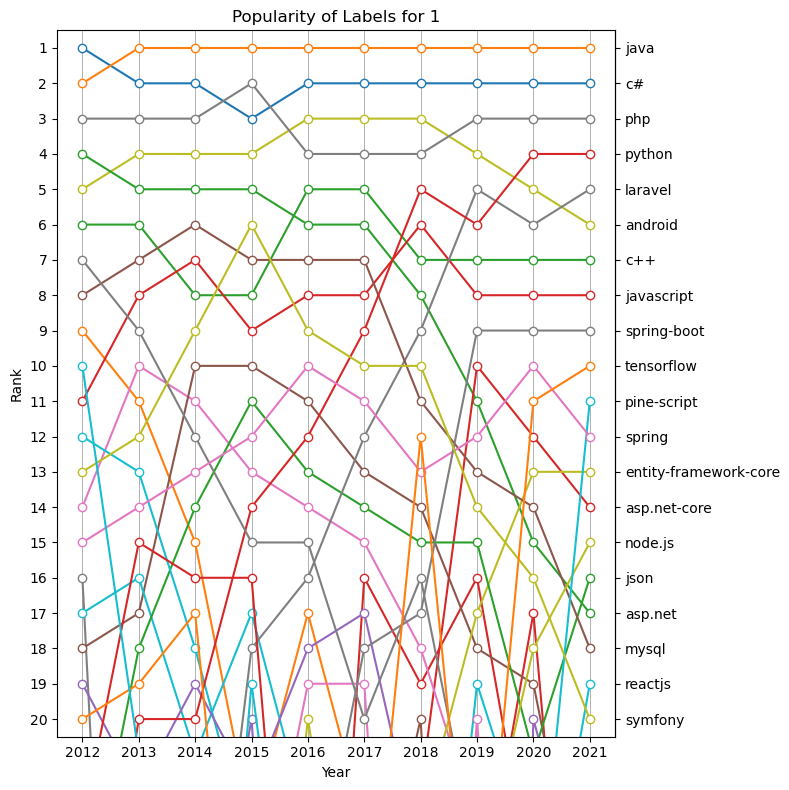

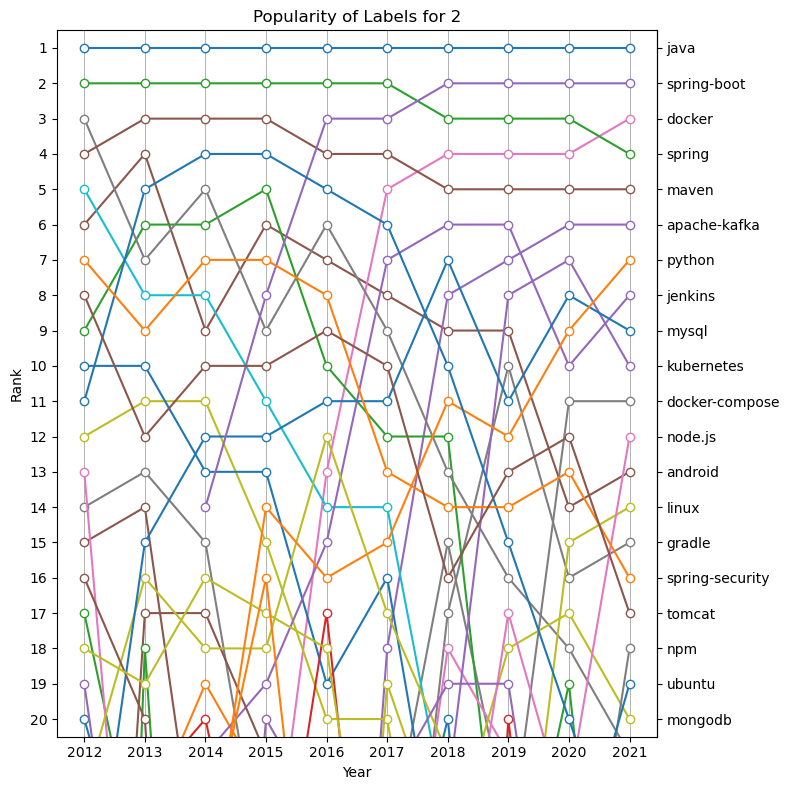

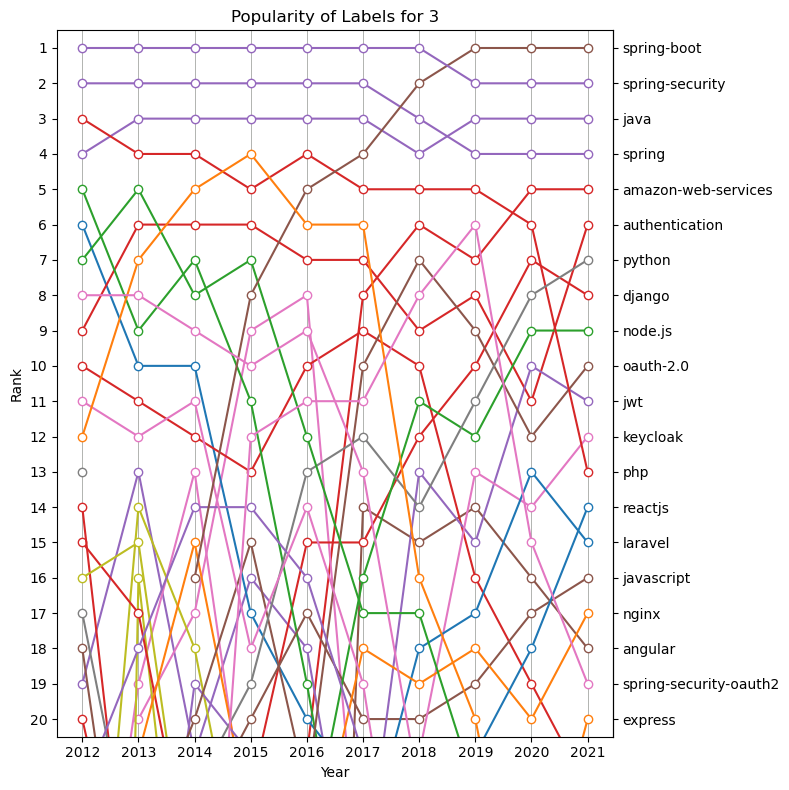

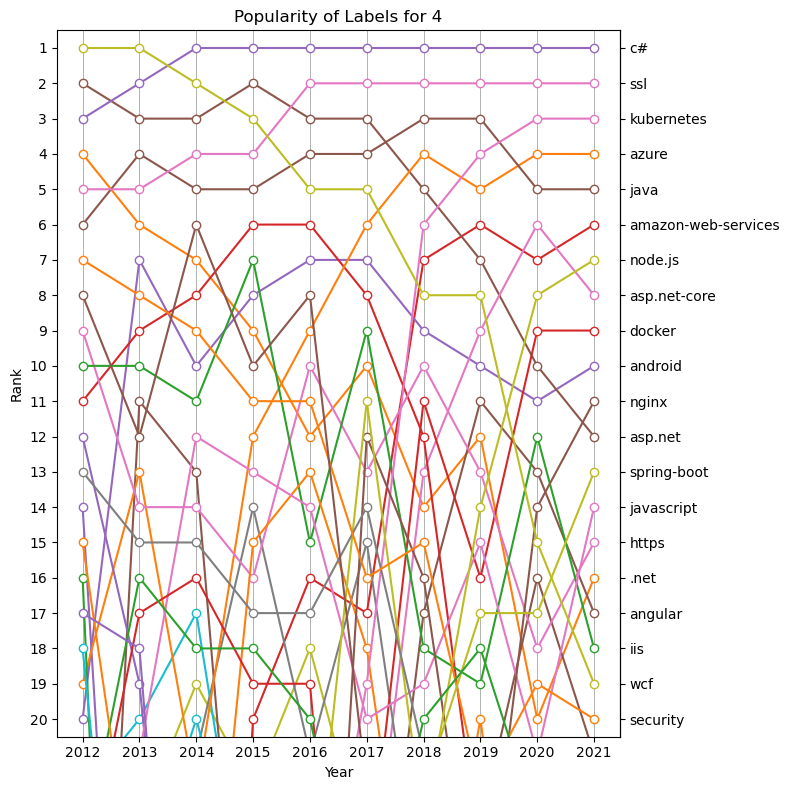

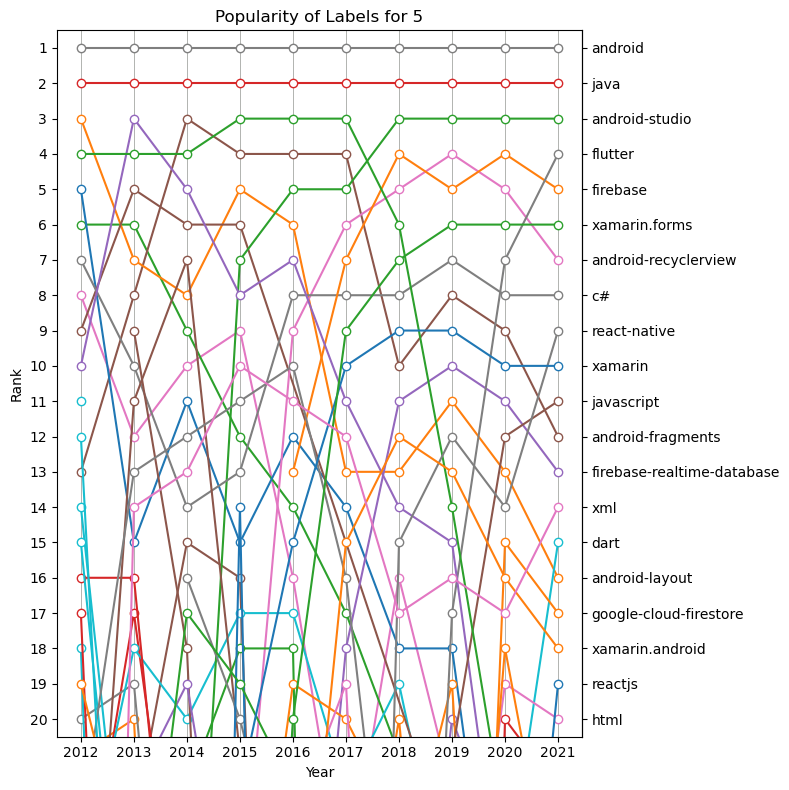

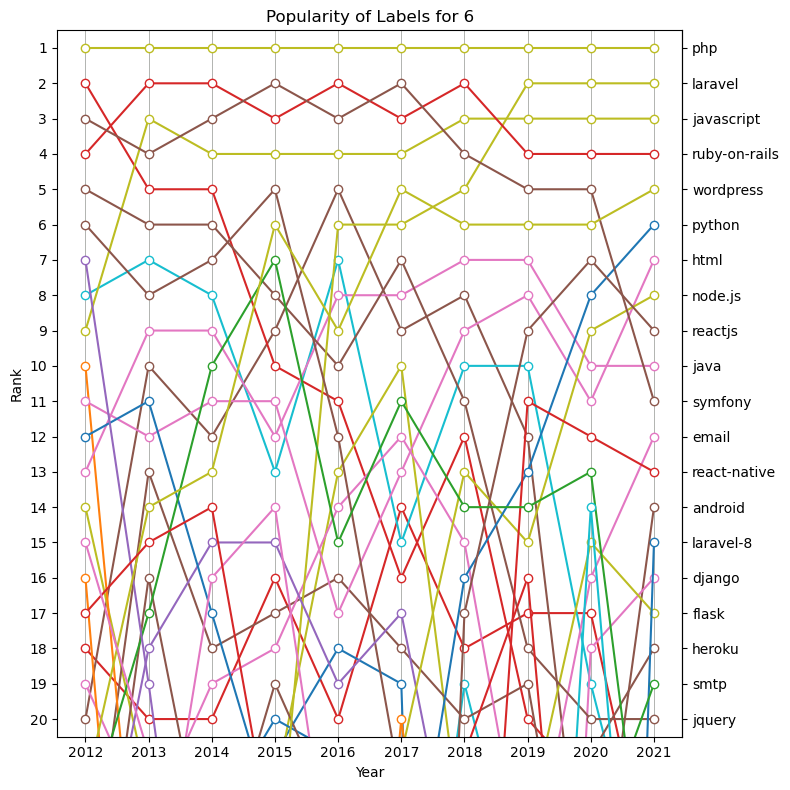

In [180]:
top_labels_dict = {}
n_top_ranked = 20
for topic in range(1, 7):
    current_df = ranking_pd_dict[topic]
    current_df = current_df.astype({'ranking':'int32', 'year':'int32'})
    top_labels_dict[topic] = current_df[current_df["year"] == current_df["year"].max()].nsmallest(n_top_ranked, "ranking")
    plot_rank(topic, current_df, top_labels_dict[topic])

In [72]:
def plot_rank_reduced(n_topic, ranking_pd, top_labels):
    n_top_ranked = len(top_labels)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    yax2 = ax.secondary_yaxis("right")
    yax2.yaxis.set_major_locator(FixedLocator(top_labels["ranking"].to_list()))
    yax2.yaxis.set_major_formatter(FixedFormatter(top_labels["label"].to_list()))
    
    top_labels_2021 = top_labels["label"].to_list()
    ranking_pd_modified = ranking_pd.loc[ranking_pd['label'].isin(top_labels_2021)]
    ranking_pd_modified = ranking_pd_modified[ranking_pd_modified['ranking'].between(1, 20)]
    
    
    for i, j in ranking_pd_modified.groupby("label"):
        sorted_j = j.sort_values(by="year")
        ax.plot("year", "ranking", "o-", data=sorted_j, mfc="w")

    ax.invert_yaxis()
    ax.set(xlabel="Year", ylabel="Rank", title="Popularity of Labels for Topic {}".format(n_topic))
    #ax.set(xlabel="Year", ylabel="Rank", title="Popularity of Labels for {}".format(n_topic))
    ax.grid(axis="x", color='xkcd:grey', linestyle='-', linewidth=0.5)

    ax.set_facecolor('xkcd:white')

    filename = '/Users/gunardiali/Downloads/ranking_topic{}_rank{}.png'.format(n_topic, n_top_ranked)
    #filename = '/Users/gunardiali/Downloads/ranking_topic_nan_rank.png'
    plt.savefig(filename, format='png', dpi=1200, bbox_inches="tight")
    plt.tight_layout()

    #plt.show()

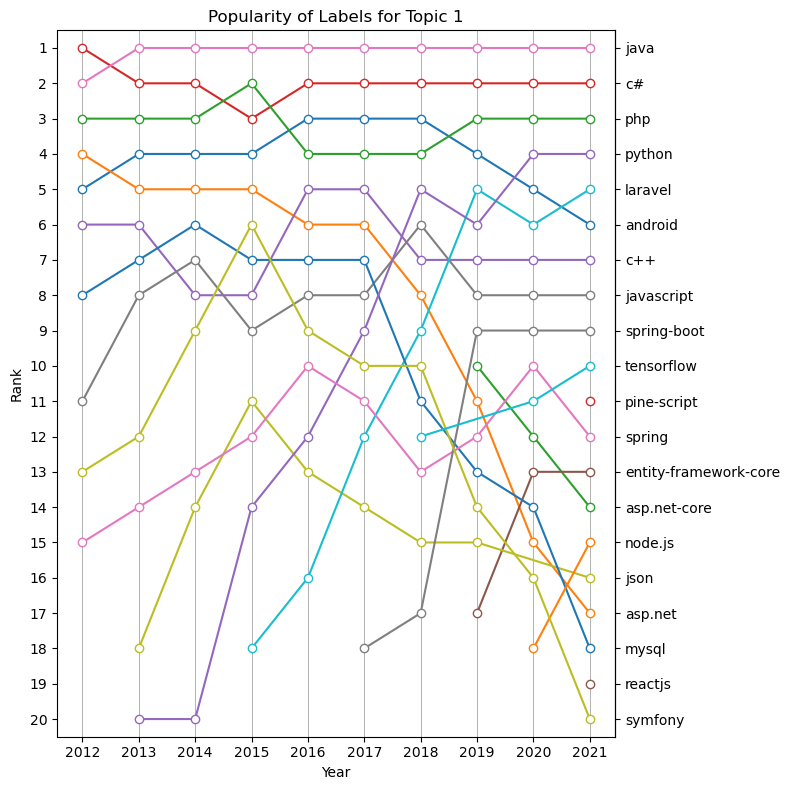

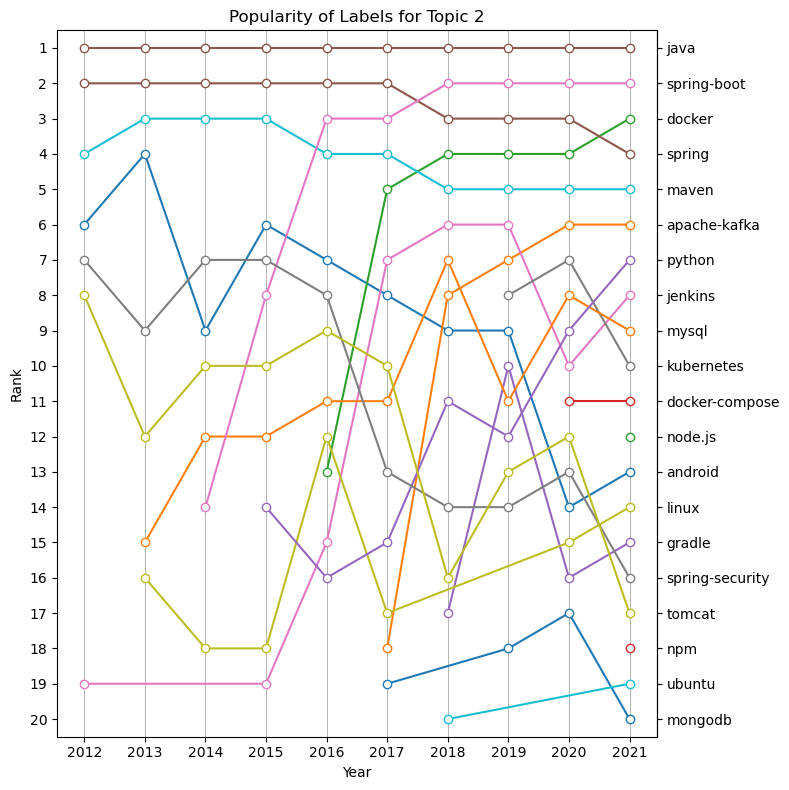

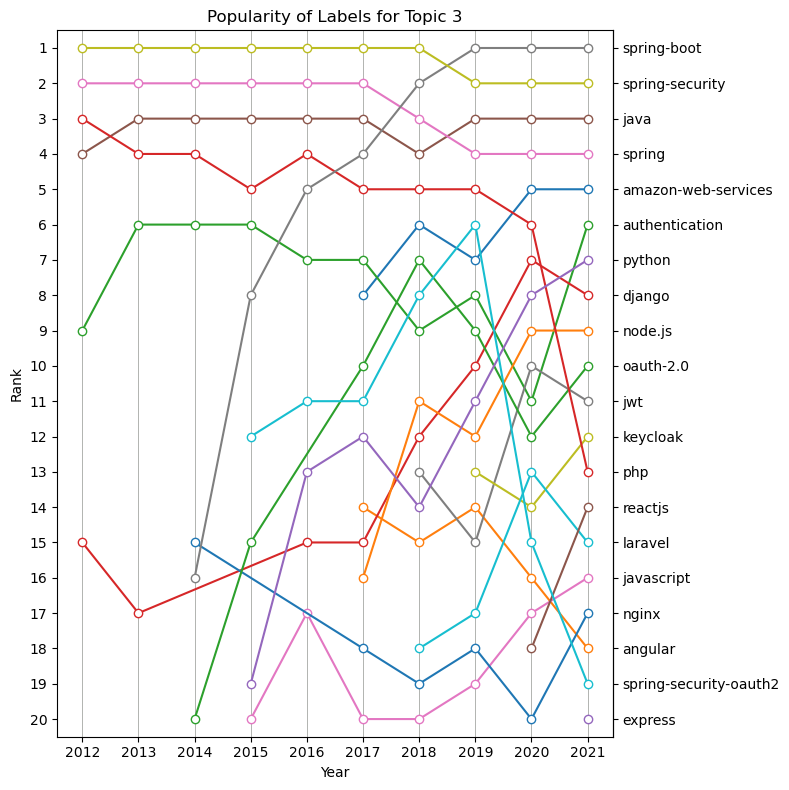

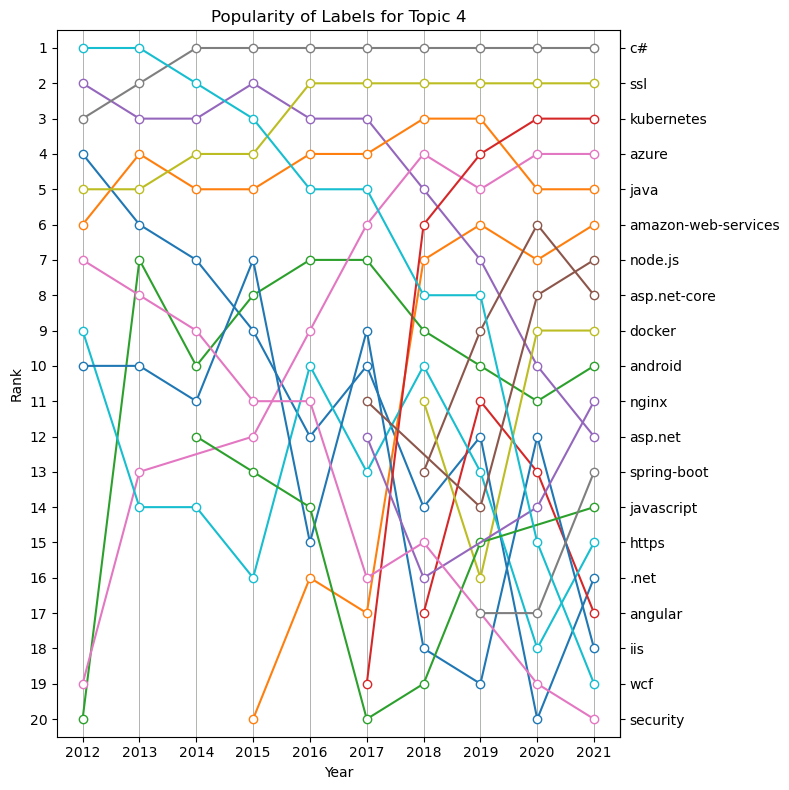

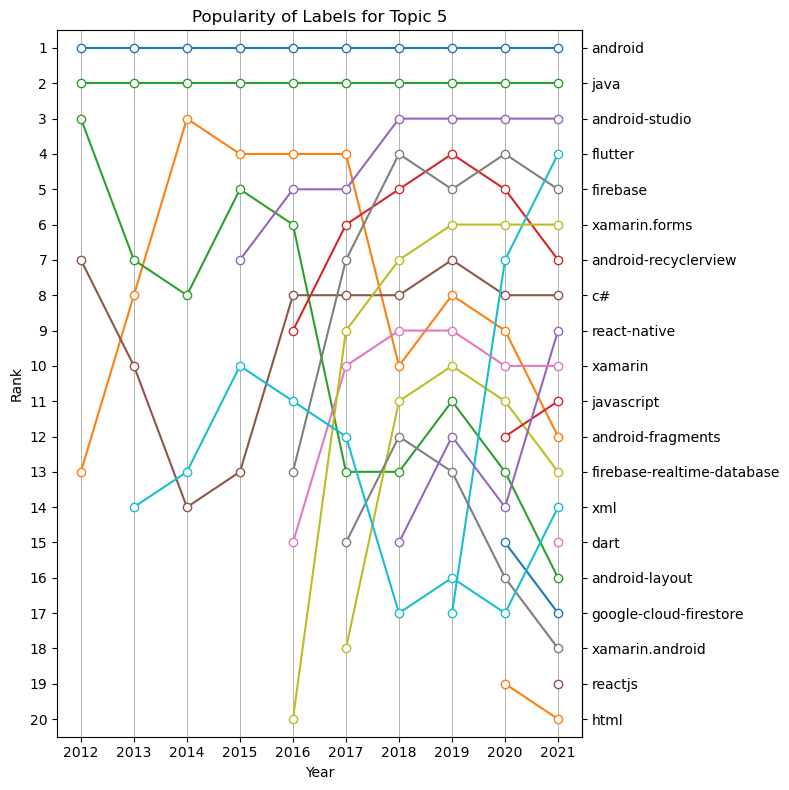

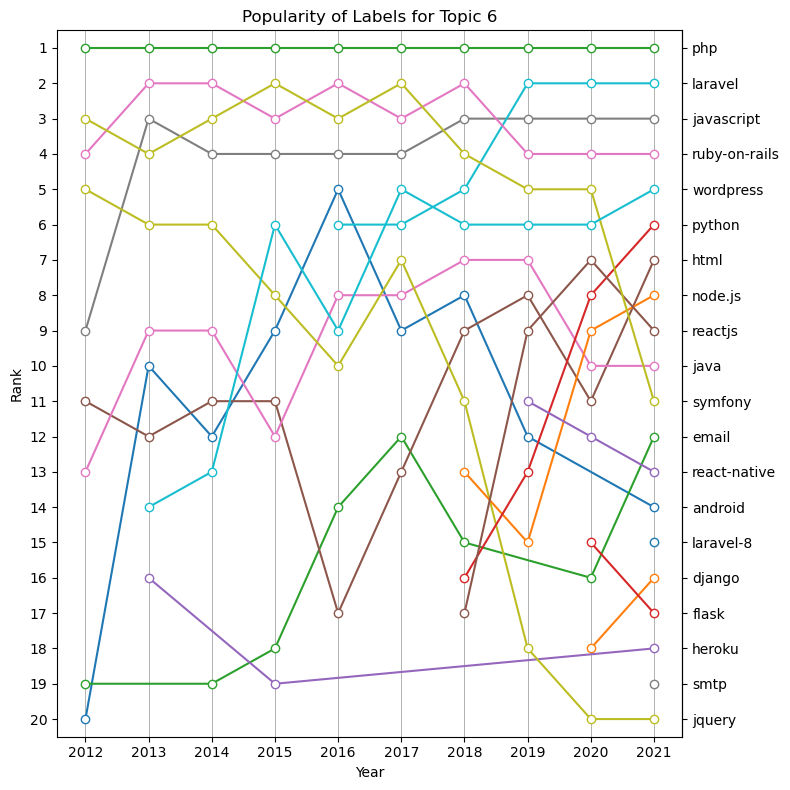

In [73]:
top_labels_dict = {}
n_top_ranked = 20
for topic in range(1, 7):
    current_df = ranking_pd_dict[topic]
    current_df = current_df.astype({'ranking':'int32', 'year':'int32'})
    top_labels_dict[topic] = current_df[current_df["year"] == current_df["year"].max()].nsmallest(n_top_ranked, "ranking")
    plot_rank_reduced(topic, current_df, top_labels_dict[topic])

In [77]:
current_df

year  ranking   label
0    2012        1     php
1    2013        1     php
2    2014        1     php
3    2015        1     php
4    2016        1     php
..    ...      ...     ...
995  2017      100   xampp
996  2018      100     ssl
997  2019      100  gatsby
998  2020      100     xss
999  2021      100   xampp

[1000 rows x 3 columns]

In [78]:
label_nan_df.query('label == "java"')

2012        2013        2014        2015        2016  \
label topic                                                               
java  1      107.816667  197.966667  248.633333  276.500000  269.133333   
      2      104.183333  204.683333  317.716667  366.850000  349.450000   
      3       33.883333   60.400000  109.450000  153.550000  175.683333   
      4       30.300000   38.700000   50.383333   65.083333   76.800000   
      5       32.483333  125.616667  207.783333  230.300000  244.366667   
      6        8.716667   19.616667   24.316667   23.183333   27.033333   

                   2017        2018        2019        2020        2021  
label topic                                                              
java  1      247.233333  214.383333  208.116667  200.950000  160.850000  
      2      369.366667  318.250000  262.333333  280.766667  301.733333  
      3      168.100000  164.850000  157.183333  171.650000  156.116667  
      4       66.000000   63.266667   62.866667   55.733333   65.733333  
      5      227.166667  159.816667  158.383333  141.266667  132.150000  
      6       24.083333   24.383333   16.133333   15.683333   16.583333

In [79]:
label_nan_df.query('topic == 2')

2012        2013        2014        2015  \
label          topic                                                   
java           2      104.183333  204.683333  317.716667  366.850000   
spring         2       50.766667   89.950000  149.383333  165.266667   
hibernate      2       24.333333   37.166667   50.466667   45.583333   
maven          2       20.883333   41.783333   69.916667   84.833333   
tomcat7        2        4.250000   10.316667    6.350000    9.200000   
...                          ...         ...         ...         ...   
oracle-bi      2        0.000000    0.000000    0.000000    0.000000   
att            2        0.000000    0.000000    0.000000    0.000000   
gateone        2        0.000000    0.000000    0.000000    0.000000   
.app           2        0.000000    0.000000    0.000000    0.000000   
aws-glue-spark 2        0.000000    0.000000    0.000000    0.000000   

                            2016        2017        2018        2019  \
label          topic                                                   
java           2      349.450000  369.366667  318.250000  262.333333   
spring         2      177.650000  164.633333  147.400000   98.666667   
hibernate      2       60.400000   48.650000   32.450000   22.683333   
maven          2       85.266667   87.466667   68.766667   55.000000   
tomcat7        2        5.533333    6.933333    2.716667    1.916667   
...                          ...         ...         ...         ...   
oracle-bi      2        0.000000    0.000000    0.000000    0.000000   
att            2        0.000000    0.000000    0.000000    0.000000   
gateone        2        0.000000    0.000000    0.000000    0.000000   
.app           2        0.000000    0.000000    0.000000    0.000000   
aws-glue-spark 2        0.000000    0.000000    0.000000    0.000000   

                            2020        2021  
label          topic                          
java           2      280.766667  301.733333  
spring         2      108.083333  107.916667  
hibernate      2       22.166667   21.433333  
maven          2       72.550000   74.516667  
tomcat7        2        0.000000    0.000000  
...                          ...         ...  
oracle-bi      2        0.000000    0.000000  
att            2        0.000000    0.000000  
gateone        2        0.000000    0.000000  
.app           2        0.000000    0.000000  
aws-glue-spark 2        0.000000    0.000000  

[19925 rows x 10 columns]

In [80]:
total_nan_df = label_nan_df.groupby('label').sum()
total_nan_df.head()

2012   2013       2014  2015   2016  2017       2018  \
label                                                                     
.app           0.000000   0.00   0.000000   0.0   0.00   0.0   0.200000   
.aspxauth      0.000000   0.20   0.200000   0.0   0.00   0.0   0.000000   
.bash-profile  0.000000   0.00   0.200000   0.0   0.20   0.0   0.000000   
.class-file    0.000000   0.00   0.000000   0.0   0.25   0.0   0.000000   
.htaccess      9.466667  18.45  25.633333  21.0  18.75  20.6  11.066667   

                    2019      2020  2021  
label                                     
.app            0.000000  0.000000   0.0  
.aspxauth       0.000000  0.000000   0.0  
.bash-profile   0.000000  0.000000   0.0  
.class-file     0.000000  0.250000   0.0  
.htaccess      12.633333  6.216667   8.9

In [81]:
total_nan_ranking = {}
for year in total_nan_df:
    temp_df = total_nan_df.sort_values(
        by=[year], ascending=False)
    total_nan_ranking[year] = temp_df.index.tolist()[:100]
total_nan_rank_df = pd.DataFrame.from_dict(total_nan_ranking)

In [82]:
total_nan_rank_df

2012       2013               2014                    2015  \
0       android    android            android                 android   
1          java       java               java                    java   
2            c#        php                php                     php   
3           php         c#                 c#                      c#   
4       asp.net    asp.net             spring                  spring   
..          ...        ...                ...                     ...   
95       heroku    tomcat7             django                  sqlite   
96   deployment          c             sqlite                  devise   
97        email   jboss7.x  android-actionbar                  heroku   
98    exception      jsf-2          oauth-2.0                  ubuntu   
99  silverlight  angularjs    zend-framework2  google-cloud-messaging   

                2016             2017             2018             2019  \
0            android          android             java             java   
1               java             java          android          android   
2                php              php      spring-boot      spring-boot   
3                 c#               c#               c#               c#   
4             spring           spring              php              php   
..               ...              ...              ...              ...   
95          facebook              jwt            swift              git   
96       laravel-5.2              jsp  identityserver4             cors   
97  android-activity  xamarin.android   multithreading         jhipster   
98               sql            flask          windows  ssl-certificate   
99          winforms              git  spring-data-jpa              sql   

                 2020          2021  
0                java          java  
1         spring-boot   spring-boot  
2             android       android  
3                  c#            c#  
4              spring           php  
..                ...           ...  
95              macos            go  
96    spring-data-jpa           xml  
97  google-app-engine  apache-spark  
98                  r         proxy  
99                  c       webpack  

[100 rows x 10 columns]

In [83]:
ranking_dict = {}

temp_df = total_nan_rank_df.T
temp_df.index.name='year'
temp_df.reset_index(inplace=True)
total_nan_ranking_df = temp_df

In [84]:
total_nan_ranking_df

year        0            1            2    3        4                5  \
0  2012  android         java           c#  php  asp.net              wcf   
1  2013  android         java          php   c#  asp.net           spring   
2  2014  android         java          php   c#   spring          asp.net   
3  2015  android         java          php   c#   spring  spring-security   
4  2016  android         java          php   c#   spring  spring-security   
5  2017  android         java          php   c#   spring      spring-boot   
6  2018     java      android  spring-boot   c#      php           spring   
7  2019     java      android  spring-boot   c#      php           spring   
8  2020     java  spring-boot      android   c#   spring              php   
9  2021     java  spring-boot      android   c#      php           spring   

                 6                7           8  ...              90  \
0           spring  spring-security    security  ...        jboss7.x   
1  spring-security              wcf    security  ...         cookies   
2  spring-security          symfony         wcf  ...          heroku   
3          asp.net       spring-mvc     symfony  ...          docker   
4          asp.net      spring-boot  spring-mvc  ...         angular   
5  spring-security          asp.net     symfony  ...  android-layout   
6  spring-security           python  javascript  ...        database   
7  spring-security           python     laravel  ...         windows   
8  spring-security           python     laravel  ...   intellij-idea   
9           python  spring-security  javascript  ...          gitlab   

                     91                    92                      93  \
0  forms-authentication           certificate                  applet   
1                 forms  nullpointerexception             apache-flex   
2  nullpointerexception            encryption                    wso2   
3         asp.net-mvc-4           codeigniter                 cordova   
4               wildfly                   jpa                  gradle   
5                javafx                 oauth                database   
6                   api       xamarin.android   entity-framework-core   
7               wildfly                     c        jenkins-pipeline   
8                hadoop          apache-spark                  kotlin   
9               next.js                   iis  google-cloud-firestore   

                94        95               96                 97  \
0          iis-7.5    heroku       deployment              email   
1     doctrine-orm   tomcat7                c           jboss7.x   
2             ldap    django           sqlite  android-actionbar   
3              sql    sqlite           devise             heroku   
4         database  facebook      laravel-5.2   android-activity   
5       jakarta-ee       jwt              jsp    xamarin.android   
6       typescript     swift  identityserver4     multithreading   
7             ajax       git             cors           jhipster   
8             cors     macos  spring-data-jpa  google-app-engine   
9  ssl-certificate        go              xml       apache-spark   

                98                      99  
0        exception             silverlight  
1            jsf-2               angularjs  
2        oauth-2.0         zend-framework2  
3           ubuntu  google-cloud-messaging  
4              sql                winforms  
5            flask                     git  
6          windows         spring-data-jpa  
7  ssl-certificate                     sql  
8                r                       c  
9            proxy                 webpack  

[10 rows x 101 columns]

In [85]:
ranking_nan_pd = pd.melt(total_nan_ranking_df, id_vars=['year'], value_vars=list(range(0,100)), var_name='ranking',
                value_name='label')
ranking_nan_pd.loc[:,['ranking']]+=1
ranking_nan_pd

year ranking            label
0    2012       1          android
1    2013       1          android
2    2014       1          android
3    2015       1          android
4    2016       1          android
..    ...     ...              ...
995  2017     100              git
996  2018     100  spring-data-jpa
997  2019     100              sql
998  2020     100                c
999  2021     100          webpack

[1000 rows x 3 columns]

In [86]:
current_df = ranking_nan_pd
current_df = current_df.astype({'ranking':'int32', 'year':'int32'})
top_labels = current_df[current_df["year"] == current_df["year"].max()].nsmallest(n_top_ranked, "ranking")
#plot_rank(topic, current_df, top_labels_dict[topic])
top_labels

year  ranking                label
9    2021        1                 java
19   2021        2          spring-boot
29   2021        3              android
39   2021        4                   c#
49   2021        5                  php
59   2021        6               spring
69   2021        7               python
79   2021        8      spring-security
89   2021        9           javascript
99   2021       10               docker
109  2021       11              laravel
119  2021       12              node.js
129  2021       13  amazon-web-services
139  2021       14           kubernetes
149  2021       15                  ssl
159  2021       16              reactjs
169  2021       17               django
179  2021       18              angular
189  2021       19         asp.net-core
199  2021       20       authentication

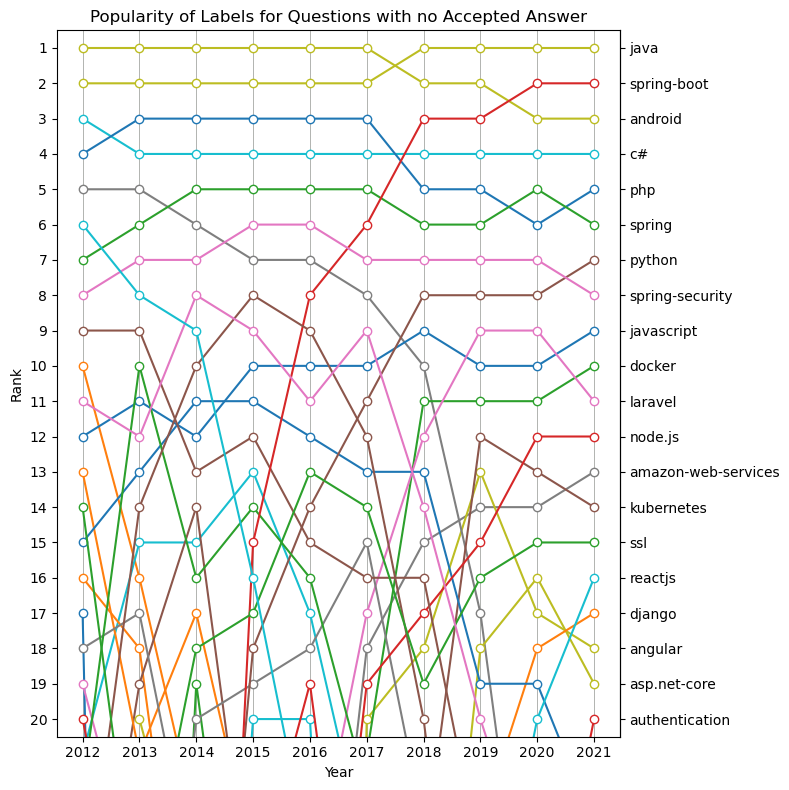

In [87]:
plot_rank(20, ranking_nan_pd, top_labels)

In [88]:
ranking_nan_pd.head(20)

year ranking        label
0   2012       1      android
1   2013       1      android
2   2014       1      android
3   2015       1      android
4   2016       1      android
5   2017       1      android
6   2018       1         java
7   2019       1         java
8   2020       1         java
9   2021       1         java
10  2012       2         java
11  2013       2         java
12  2014       2         java
13  2015       2         java
14  2016       2         java
15  2017       2         java
16  2018       2      android
17  2019       2      android
18  2020       2  spring-boot
19  2021       2  spring-boot

In [89]:
total_path = "/Users/gunardiali/Downloads/bquxjob_1d66497e_18694623945.csv"

In [90]:
total_df = pd.read_csv(total_path)

In [91]:
total_df.head()

year duration_cat   total   freq
0  2012       <1 day  906371  55.63
1  2012      <3 days   46725   2.87
2  2012     <1 month   62754   3.85
3  2012    >=1 month   46946   2.88
4  2012    No Answer  566590  34.77

In [92]:
total_df.groupby('year')['total'].sum()

year
2012    1629386
2013    2033690
2014    2137435
2015    2196676
2016    2200802
2017    2116212
2018    1888989
2019    1766933
2020    1871695
2021    1629580
Name: total, dtype: int64

In [93]:
colors = ['#2c7bb6', '#abd9e9', '#fdae61', '#d7191c', '#d9d9d9']

In [94]:
fig = px.histogram(total_df.reset_index(), x="year", y="freq", color="duration_cat",
                  color_discrete_sequence=colors, nbins=10)
fig.update_layout(legend_title_text='Duration:', yaxis_title="Relative Distribution (%)",
                 xaxis_title="Year")
#fig.update_layout(title_text="Answer Duration", title_x=0.5, title_y=0.95)
fig.update_layout(bargap=0.2)
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)',
                  'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='black')
#fig.update_layout(legend_traceorder="reversed")
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [95]:
new_df = total_df.groupby('year').apply(
    lambda x: x[x['duration_cat'] != 'No Answer']['total'].sum()).to_frame('total')

In [96]:
new_df.loc[:,'type'] = 'yes'

In [97]:
new_df.head()

total type
year              
2012  1062796  yes
2013  1174340  yes
2014  1159889  yes
2015  1117849  yes
2016  1074099  yes

In [98]:
no_answer_df = total_df.groupby('year').apply(
    lambda x: x[x['duration_cat'] == 'No Answer']['total'].sum()).to_frame('total')
no_answer_df.loc[:,'type'] = 'no'
no_answer_df.head()

total type
year              
2012   566590   no
2013   859350   no
2014   977546   no
2015  1078827   no
2016  1126703   no

In [99]:
total_df = pd.concat([new_df, no_answer_df])#.sort_values(by=['year', 'type'])
total_df.head()

total type
year              
2012  1062796  yes
2013  1174340  yes
2014  1159889  yes
2015  1117849  yes
2016  1074099  yes

In [100]:
total_df.reset_index(inplace=True)

In [101]:
fig = px.histogram(total_df, x="year", y="total", color="type", nbins=10,
                  color_discrete_sequence=['#1f78b4', '#a6cee3'])
#'#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4'
fig.update_layout(legend_title_text='Accepted Answer Available?', yaxis_title="Annual Amount of Questions",
                 xaxis_title="Year")
#fig.update_layout(title_text="Total Annual Questions", title_x=0.5, title_y=0.95)
fig.update_layout(bargap=0.2)
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)',
                  'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='black')
#fig.update_layout(legend_traceorder="reversed")
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [102]:
total_path = "/Users/gunardiali/Downloads/bquxjob_1d66497e_18694623945.csv"
sec_path = "/Users/gunardiali/Downloads/sec.csv"

In [103]:
total_df = pd.read_csv(total_path)
sec_df = pd.read_csv(sec_path)

In [104]:
total_df.head()

year duration_cat   total   freq
0  2012       <1 day  906371  55.63
1  2012      <3 days   46725   2.87
2  2012     <1 month   62754   3.85
3  2012    >=1 month   46946   2.88
4  2012    No Answer  566590  34.77

In [105]:
len(total_df)

50

In [106]:
sec_df.head(20)

year  diff_day  post_num  total  post_num_%   category
0   2012         0      8022  17834   44.981496     <1 day
1   2012         1       556  17834    3.117640   < 3 days
2   2012         2       297  17834    1.665358   < 3 days
3   2012         3       191  17834    1.070988   < 3 days
4   2012         4       150  17834    0.841090  < 1 month
5   2012         5       140  17834    0.785017  < 1 month
6   2012         6       100  17834    0.560727  < 1 month
7   2012         7        78  17834    0.437367  < 1 month
8   2012         8        76  17834    0.426152  < 1 month
9   2012         9        48  17834    0.269149  < 1 month
10  2012        10        33  17834    0.185040  < 1 month
11  2012        11        33  17834    0.185040  < 1 month
12  2012        12        39  17834    0.218683  < 1 month
13  2012        13        44  17834    0.246720  < 1 month
14  2012        14        30  17834    0.168218  < 1 month
15  2012        15        33  17834    0.185040  < 1 month
16  2012        16        13  17834    0.072894  < 1 month
17  2012        17        13  17834    0.072894  < 1 month
18  2012        18        15  17834    0.084109  < 1 month
19  2012        19        15  17834    0.084109  < 1 month

In [107]:
len(sec_df)

7065

In [108]:
sec_df.category.unique()

array(['<1 day', '< 3 days', '< 1 month', '>= 1 month', 'No Answer'],
      dtype=object)

In [109]:
sec_df.drop(sec_df[(sec_df['category'] == '>= 1 month') | (sec_df['category'] == 'No Answer')].index, inplace=True)

In [110]:
#sec_df.groupby(['year', 'category']).sum()
sec_df.head()

year  diff_day  post_num  total  post_num_%   category
0  2012         0      8022  17834   44.981496     <1 day
1  2012         1       556  17834    3.117640   < 3 days
2  2012         2       297  17834    1.665358   < 3 days
3  2012         3       191  17834    1.070988   < 3 days
4  2012         4       150  17834    0.841090  < 1 month

In [111]:
sec_summary_df = sec_df.groupby('year')[['post_num', 'post_num_%']].sum()
sec_summary_df.head()

post_num  post_num_%
year                      
2012     10083   56.538073
2013     12499   49.015686
2014     13042   45.223482
2015     13165   41.969523
2016     12560   40.076579

In [112]:
total_df.head()

year duration_cat   total   freq
0  2012       <1 day  906371  55.63
1  2012      <3 days   46725   2.87
2  2012     <1 month   62754   3.85
3  2012    >=1 month   46946   2.88
4  2012    No Answer  566590  34.77

In [113]:
total_df.drop(total_df[(total_df['duration_cat'] == '>=1 month') | (total_df['duration_cat'] == 'No Answer')].index, inplace=True)

In [114]:
total_df.head(10)

year duration_cat    total   freq
0   2012       <1 day   906371  55.63
1   2012      <3 days    46725   2.87
2   2012     <1 month    62754   3.85
5   2013       <1 day  1010557  49.69
6   2013      <3 days    52489   2.58
7   2013     <1 month    65868   3.24
10  2014       <1 day   992171  46.42
11  2014      <3 days    56810   2.66
12  2014     <1 month    67899   3.18
15  2015       <1 day   951566  43.32

In [115]:
total_summary_df = total_df.set_index('year').groupby('year').sum().loc[:,['total', 'freq']]
total_summary_df.head(20)

/var/folders/8k/661zw29d2hvbygdm3fn9_dz40000gn/T/ipykernel_11223/818052842.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



total   freq
year                
2012  1015850  62.35
2013  1128914  55.51
2014  1116880  52.26
2015  1077640  49.06
2016  1036876  47.11
2017   967154  45.70
2018   843345  44.65
2019   776865  43.96
2020   815970  43.59
2021   643999  39.52

In [116]:
sec_summary_df.rename({'post_num':'total', 'post_num_%':'freq'}, axis=1, inplace=True)
sec_summary_df.head()

total       freq
year                  
2012  10083  56.538073
2013  12499  49.015686
2014  13042  45.223482
2015  13165  41.969523
2016  12560  40.076579

In [117]:
len(sec_summary_df), len(total_summary_df)

(10, 10)

In [118]:
sec_summary_df.loc[:,'category'] = 'security'
total_summary_df.loc[:,'category'] = 'all'

In [119]:
sec_summary_df.head(26)

total       freq  category
year                            
2012  10083  56.538073  security
2013  12499  49.015686  security
2014  13042  45.223482  security
2015  13165  41.969523  security
2016  12560  40.076579  security
2017  11100  38.026721  security
2018   9690  36.767217  security
2019   8520  36.106285  security
2020   8926  34.834530  security
2021   6612  26.986654  security

In [120]:
total_summary_df.head(26)

total   freq category
year                         
2012  1015850  62.35      all
2013  1128914  55.51      all
2014  1116880  52.26      all
2015  1077640  49.06      all
2016  1036876  47.11      all
2017   967154  45.70      all
2018   843345  44.65      all
2019   776865  43.96      all
2020   815970  43.59      all
2021   643999  39.52      all

In [121]:
concat_df = pd.concat([sec_summary_df, total_summary_df], axis=0)

In [122]:
concat_df.head()

total       freq  category
year                            
2012  10083  56.538073  security
2013  12499  49.015686  security
2014  13042  45.223482  security
2015  13165  41.969523  security
2016  12560  40.076579  security

In [123]:
len(concat_df)

20

In [124]:
colors = ['#d73027','#4575b4']
fig = px.line(concat_df.reset_index(), x="year", y="freq", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Relative Percentage",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [125]:
import plotly.graph_objects as go

In [126]:
colors = ['#d73027','#4575b4']
fig = px.line(concat_df.reset_index(), x="year", y="freq", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Relative Percentage",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.add_annotation(dict(
                x= 2016,
                y= 40,
                xref="x", yref="y",
                yanchor='bottom',
                xanchor='left',
                axref = 'x', ayref='y',
                ax= 2016,
                ay= 47.11,
                arrowhead = 3,
                arrowwidth=2.5,
                arrowcolor='black',)
            )
fig.add_annotation(x=2016, y=42, 
            text=f'Lower portion<br>for "security"',
            align='left',
            showarrow=False,
            xshift=50,
            yshift=10)
fig.show()

In [127]:
colors = ['#d73027','#4575b4']
fig = px.line(concat_df.reset_index(), x="year", y="freq", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Relative Percentage",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.add_annotation(dict(
                x= 2016,
                y= 40,
                xref="x", yref="y",
                yanchor='bottom',
                xanchor='left',
                axref = 'x', ayref='y',
                ax= 2016,
                ay= 47.11,
                arrowhead = 3,
                arrowwidth=2.5,
                arrowcolor='black',)
            )
fig.add_annotation(x=2016, y=42, 
            text=f'Lower portion<br>for "security"',
            align='left',
            showarrow=False,
            xshift=50,
            bordercolor='black',
            borderwidth=1,
            bgcolor="#ffffff",
            font=dict(
                color="black"),
            yshift=10)
fig.add_annotation(x=2019.5, y=35, 
            text=f'Stronger downward<br>trend for "security"',
            align='left',
            showarrow=False,
            xshift=46,
            yshift=26,
            bordercolor='black',
            borderwidth=1,
            bgcolor="#ffffff", 
            font=dict(
                #family="sans serif",
                #size=18,
                color="black"))
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'y', y0= '56.53', y1= '62.35',
                        xref= 'x', x0='2012', x1='2012',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                        ),
                  dict(type= 'line',
                        yref= 'y', y0= '26.98', y1= '39.52',
                        xref= 'x', x0='2021', x1='2021',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                       )
                  ])

fig.show()

In [128]:
all_kpi_path = '/Users/gunardiali/Downloads/all_kpi.csv'
secur_kpi_path = '/Users/gunardiali/Downloads/secur_kpi.csv'

In [129]:
all_kpi_df = pd.read_csv(all_kpi_path)
secur_kpi_df = pd.read_csv(secur_kpi_path)

In [130]:
secur_kpi_df.loc[:,'category'] = 'security'
secur_kpi_df.head()

year    ans    com        vie  total  ans_mean  com_mean  vie_mean  \
0  2012  29732  32380   79211542  17829      1.67      1.82   4442.85   
1  2013  38914  54394  107404454  25432      1.53      2.14   4223.20   
2  2014  39583  66449   88140933  28763      1.38      2.31   3064.39   
3  2015  40031  75195   78477473  31351      1.28      2.40   2503.19   
4  2016  37994  75189   72625218  31318      1.21      2.40   2318.96   

   category  
0  security  
1  security  
2  security  
3  security  
4  security

In [131]:
all_kpi_df.loc[:,'category'] = 'all'
all_kpi_df.head()

year      ans      com         vie    total  ans_mean  com_mean  vie_mean  \
0  2012  3063015  2663484  8574454342  1629386      1.88      1.63   5262.38   
1  2013  3473182  3951067  8754359903  2033690      1.71      1.94   4304.67   
2  2014  3242684  4428040  5816979621  2137435      1.52      2.07   2721.48   
3  2015  3133535  4771537  4898174768  2196676      1.43      2.17   2229.81   
4  2016  3023955  4878489  4542887787  2200802      1.37      2.22   2064.20   

  category  
0      all  
1      all  
2      all  
3      all  
4      all

In [132]:
all_kpi_df.loc[:,['year', 'category', 'ans_mean', 'com_mean', 'vie_mean']]

year category  ans_mean  com_mean  vie_mean
0  2012      all      1.88      1.63   5262.38
1  2013      all      1.71      1.94   4304.67
2  2014      all      1.52      2.07   2721.48
3  2015      all      1.43      2.17   2229.81
4  2016      all      1.37      2.22   2064.20
5  2017      all      1.32      2.30   1846.36
6  2018      all      1.27      2.32   1492.83
7  2019      all      1.24      2.19   1036.93
8  2020      all      1.16      2.04    687.96
9  2021      all      1.04      1.97    386.83

In [133]:
kpi_df = pd.concat([secur_kpi_df.loc[:,['year', 'category', 'ans_mean', 'com_mean', 'vie_mean']], all_kpi_df.loc[:,['year', 'category', 'ans_mean', 'com_mean', 'vie_mean']]], axis=0, ignore_index=True)

In [134]:
kpi_df

year  category  ans_mean  com_mean  vie_mean
0   2012  security      1.67      1.82   4442.85
1   2013  security      1.53      2.14   4223.20
2   2014  security      1.38      2.31   3064.39
3   2015  security      1.28      2.40   2503.19
4   2016  security      1.21      2.40   2318.96
5   2017  security      1.15      2.48   2020.31
6   2018  security      1.13      2.50   1915.17
7   2019  security      1.06      2.40   1442.84
8   2020  security      1.00      2.25   1115.48
9   2021  security      0.87      2.16    625.19
10  2012       all      1.88      1.63   5262.38
11  2013       all      1.71      1.94   4304.67
12  2014       all      1.52      2.07   2721.48
13  2015       all      1.43      2.17   2229.81
14  2016       all      1.37      2.22   2064.20
15  2017       all      1.32      2.30   1846.36
16  2018       all      1.27      2.32   1492.83
17  2019       all      1.24      2.19   1036.93
18  2020       all      1.16      2.04    687.96
19  2021       all      1.04      1.97    386.83

In [135]:
colors = ['#d73027','#4575b4']
fig = px.line(kpi_df.reset_index(), x="year", y="vie_mean", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Average View Count / Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [136]:
colors = ['#d73027','#4575b4']
fig = px.line(kpi_df.reset_index(), x="year", y="vie_mean", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Average View Count / Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'y', y0= '0', y1= '5300',
                        xref= 'x', x0='2013.3', x1='2013.3',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                        )])
fig.show()

In [137]:
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'y', y0= '56.53', y1= '62.35',
                        xref= 'x', x0='2012', x1='2012',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                        ),
                  dict(type= 'line',
                        yref= 'y', y0= '26.98', y1= '39.52',
                        xref= 'x', x0='2021', x1='2021',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                       )
                  ])

In [138]:
colors = ['#d73027','#4575b4']
fig = px.line(kpi_df.reset_index(), x="year", y="ans_mean", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Average Answer Count / Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [139]:
colors = ['#d73027','#4575b4']
fig = px.line(kpi_df.reset_index(), x="year", y="com_mean", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Average Comment Count / Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [140]:
kpi_df.head()

year  category  ans_mean  com_mean  vie_mean
0  2012  security      1.67      1.82   4442.85
1  2013  security      1.53      2.14   4223.20
2  2014  security      1.38      2.31   3064.39
3  2015  security      1.28      2.40   2503.19
4  2016  security      1.21      2.40   2318.96

In [141]:
ans_df = kpi_df.loc[:,['year', 'ans_mean']]
ans_df.head()

year  ans_mean
0  2012      1.67
1  2013      1.53
2  2014      1.38
3  2015      1.28
4  2016      1.21

In [142]:
ans_df.loc[:,['category']] = 'Answer for topic: ' + kpi_df.loc[:,['category']].astype(str)
ans_df.rename(columns={'ans_mean': 'Average Value For Each Question'}, inplace=True)
ans_df.head()

year  Average Value For Each Question                    category
0  2012                             1.67  Answer for topic: security
1  2013                             1.53  Answer for topic: security
2  2014                             1.38  Answer for topic: security
3  2015                             1.28  Answer for topic: security
4  2016                             1.21  Answer for topic: security

In [143]:
ans_df

year  Average Value For Each Question                    category
0   2012                             1.67  Answer for topic: security
1   2013                             1.53  Answer for topic: security
2   2014                             1.38  Answer for topic: security
3   2015                             1.28  Answer for topic: security
4   2016                             1.21  Answer for topic: security
5   2017                             1.15  Answer for topic: security
6   2018                             1.13  Answer for topic: security
7   2019                             1.06  Answer for topic: security
8   2020                             1.00  Answer for topic: security
9   2021                             0.87  Answer for topic: security
10  2012                             1.88       Answer for topic: all
11  2013                             1.71       Answer for topic: all
12  2014                             1.52       Answer for topic: all
13  2015                             1.43       Answer for topic: all
14  2016                             1.37       Answer for topic: all
15  2017                             1.32       Answer for topic: all
16  2018                             1.27       Answer for topic: all
17  2019                             1.24       Answer for topic: all
18  2020                             1.16       Answer for topic: all
19  2021                             1.04       Answer for topic: all

In [144]:
com_df = kpi_df.loc[:,['year', 'com_mean']]
com_df.head()

year  com_mean
0  2012      1.82
1  2013      2.14
2  2014      2.31
3  2015      2.40
4  2016      2.40

In [145]:
com_df.loc[:,['category']] = 'Comment for topic: ' + kpi_df.loc[:,['category']].astype(str)
com_df.rename(columns={'com_mean': 'Average Value For Each Question'}, inplace=True)
com_df.head()

year  Average Value For Each Question                     category
0  2012                             1.82  Comment for topic: security
1  2013                             2.14  Comment for topic: security
2  2014                             2.31  Comment for topic: security
3  2015                             2.40  Comment for topic: security
4  2016                             2.40  Comment for topic: security

In [146]:
len(com_df), len(ans_df)

(20, 20)

In [147]:
concat_kpi_df = pd.concat([com_df, ans_df], axis=0)
concat_kpi_df.head()

year  Average Value For Each Question                     category
0  2012                             1.82  Comment for topic: security
1  2013                             2.14  Comment for topic: security
2  2014                             2.31  Comment for topic: security
3  2015                             2.40  Comment for topic: security
4  2016                             2.40  Comment for topic: security

In [148]:
len(concat_kpi_df)

40

In [149]:
#colors = ['#d73027','#4575b4']
colors = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
fig = px.line(concat_kpi_df.reset_index(), x="year", y="Average Value For Each Question", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Legend:', yaxis_title="Average Value For Each Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [150]:
concat_kpi_df.loc[:,'level'] = np.NaN
concat_kpi_df.head()

year  Average Value For Each Question                     category  level
0  2012                             1.82  Comment for topic: security    NaN
1  2013                             2.14  Comment for topic: security    NaN
2  2014                             2.31  Comment for topic: security    NaN
3  2015                             2.40  Comment for topic: security    NaN
4  2016                             2.40  Comment for topic: security    NaN

In [151]:
concat_kpi_df.loc[(concat_kpi_df['category'].isin(['Comment for topic: security','Comment for topic: all'])),'level'] = 'comment'
concat_kpi_df.loc[(concat_kpi_df['category'].isin(['Answer for topic: security','Answer for topic: all'])),'level'] = 'answer'
concat_kpi_df

year  Average Value For Each Question                     category  \
0   2012                             1.82  Comment for topic: security   
1   2013                             2.14  Comment for topic: security   
2   2014                             2.31  Comment for topic: security   
3   2015                             2.40  Comment for topic: security   
4   2016                             2.40  Comment for topic: security   
5   2017                             2.48  Comment for topic: security   
6   2018                             2.50  Comment for topic: security   
7   2019                             2.40  Comment for topic: security   
8   2020                             2.25  Comment for topic: security   
9   2021                             2.16  Comment for topic: security   
10  2012                             1.63       Comment for topic: all   
11  2013                             1.94       Comment for topic: all   
12  2014                             2.07       Comment for topic: all   
13  2015                             2.17       Comment for topic: all   
14  2016                             2.22       Comment for topic: all   
15  2017                             2.30       Comment for topic: all   
16  2018                             2.32       Comment for topic: all   
17  2019                             2.19       Comment for topic: all   
18  2020                             2.04       Comment for topic: all   
19  2021                             1.97       Comment for topic: all   
0   2012                             1.67   Answer for topic: security   
1   2013                             1.53   Answer for topic: security   
2   2014                             1.38   Answer for topic: security   
3   2015                             1.28   Answer for topic: security   
4   2016                             1.21   Answer for topic: security   
5   2017                             1.15   Answer for topic: security   
6   2018                             1.13   Answer for topic: security   
7   2019                             1.06   Answer for topic: security   
8   2020                             1.00   Answer for topic: security   
9   2021                             0.87   Answer for topic: security   
10  2012                             1.88        Answer for topic: all   
11  2013                             1.71        Answer for topic: all   
12  2014                             1.52        Answer for topic: all   
13  2015                             1.43        Answer for topic: all   
14  2016                             1.37        Answer for topic: all   
15  2017                             1.32        Answer for topic: all   
16  2018                             1.27        Answer for topic: all   
17  2019                             1.24        Answer for topic: all   
18  2020                             1.16        Answer for topic: all   
19  2021                             1.04        Answer for topic: all   

      level  
0   comment  
1   comment  
2   comment  
3   comment  
4   comment  
5   comment  
6   comment  
7   comment  
8   comment  
9   comment  
10  comment  
11  comment  
12  comment  
13  comment  
14  comment  
15  comment  
16  comment  
17  comment  
18  comment  
19  comment  
0    answer  
1    answer  
2    answer  
3    answer  
4    answer  
5    answer  
6    answer  
7    answer  
8    answer  
9    answer  
10   answer  
11   answer  
12   answer  
13   answer  
14   answer  
15   answer  
16   answer  
17   answer  
18   answer  
19   answer

In [152]:
concat_kpi_df.loc[(concat_kpi_df['category'].isin(['Comment for topic: security','Answer for topic: security'])),'label'] = 'security'
concat_kpi_df.loc[(concat_kpi_df['category'].isin(['Comment for topic: all','Answer for topic: all'])),'label'] = 'all'
concat_kpi_df

year  Average Value For Each Question                     category  \
0   2012                             1.82  Comment for topic: security   
1   2013                             2.14  Comment for topic: security   
2   2014                             2.31  Comment for topic: security   
3   2015                             2.40  Comment for topic: security   
4   2016                             2.40  Comment for topic: security   
5   2017                             2.48  Comment for topic: security   
6   2018                             2.50  Comment for topic: security   
7   2019                             2.40  Comment for topic: security   
8   2020                             2.25  Comment for topic: security   
9   2021                             2.16  Comment for topic: security   
10  2012                             1.63       Comment for topic: all   
11  2013                             1.94       Comment for topic: all   
12  2014                             2.07       Comment for topic: all   
13  2015                             2.17       Comment for topic: all   
14  2016                             2.22       Comment for topic: all   
15  2017                             2.30       Comment for topic: all   
16  2018                             2.32       Comment for topic: all   
17  2019                             2.19       Comment for topic: all   
18  2020                             2.04       Comment for topic: all   
19  2021                             1.97       Comment for topic: all   
0   2012                             1.67   Answer for topic: security   
1   2013                             1.53   Answer for topic: security   
2   2014                             1.38   Answer for topic: security   
3   2015                             1.28   Answer for topic: security   
4   2016                             1.21   Answer for topic: security   
5   2017                             1.15   Answer for topic: security   
6   2018                             1.13   Answer for topic: security   
7   2019                             1.06   Answer for topic: security   
8   2020                             1.00   Answer for topic: security   
9   2021                             0.87   Answer for topic: security   
10  2012                             1.88        Answer for topic: all   
11  2013                             1.71        Answer for topic: all   
12  2014                             1.52        Answer for topic: all   
13  2015                             1.43        Answer for topic: all   
14  2016                             1.37        Answer for topic: all   
15  2017                             1.32        Answer for topic: all   
16  2018                             1.27        Answer for topic: all   
17  2019                             1.24        Answer for topic: all   
18  2020                             1.16        Answer for topic: all   
19  2021                             1.04        Answer for topic: all   

      level     label  
0   comment  security  
1   comment  security  
2   comment  security  
3   comment  security  
4   comment  security  
5   comment  security  
6   comment  security  
7   comment  security  
8   comment  security  
9   comment  security  
10  comment       all  
11  comment       all  
12  comment       all  
13  comment       all  
14  comment       all  
15  comment       all  
16  comment       all  
17  comment       all  
18  comment       all  
19  comment       all  
0    answer  security  
1    answer  security  
2    answer  security  
3    answer  security  
4    answer  security  
5    answer  security  
6    answer  security  
7    answer  security  
8    answer  security  
9    answer  security  
10   answer       all  
11   answer       all  
12   answer       all  
13   answer       all  
14   answer       all  
15   answer       all  
16   answer       all  
17   answer       all  
18   answer       all  
19   answ

In [153]:
#colors = ['#d73027','#4575b4']
colors = ['#d7191c','#2c7bb6']
fig = px.line(concat_kpi_df.reset_index(), x="year", y="Average Value For Each Question", color='label',
             color_discrete_sequence=colors, line_dash='level')
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Legend:', yaxis_title="Average Value For Each Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.add_annotation(text='Higher comment but<br>lower answer count<br>for "security"', 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='y',
                    x=0.5,
                    y=1,
                    bordercolor='black',
                    borderwidth=1,
                    bgcolor="#ffffff",
                    opacity=1,
                    font=dict(
                    #family="sans serif",
                    #size=18,
                    color="black"))
fig.show()

In [154]:
faulty_path = "/Users/gunardiali/Documents/Master_Data_Science/Semester_1/NLP_StackOverflow/Project_StackOverflow/other/model_2012-2021_1/index/faulty_data_index.pickle"
total_path = "/Users/gunardiali/Documents/Master_Data_Science/Semester_1/NLP_StackOverflow/Project_StackOverflow/other/model_2012-2021_1/index/total_data_index.pickle"

In [155]:
import pickle
def load_from_pickle(file_path):
    with open(file_path, "rb") as r:
        content = pickle.load(r)
    #print("Content from pickle: {}".format(content))
    return content

In [156]:
faulty_dict = load_from_pickle(faulty_path)
total_dict = load_from_pickle(total_path)

In [157]:
num_faulty, num_total = 0, 0
for i in range(2012, 2022):
    num_faulty += len(faulty_dict[i])
    num_total += len(total_dict[i])

In [158]:
num_faulty, num_total, num_faulty/num_total

(841, 264148, 0.0031838211911504157)

In [159]:
secur_path = "/Users/gunardiali/Downloads/secur.csv"
total_path = "/Users/gunardiali/Downloads/total.csv"

In [160]:
secur_df = pd.read_csv(secur_path)
total_df = pd.read_csv(total_path)

In [161]:
secur_df.head()

year    ans    com        vie    fav  score  total  ans_mean  com_mean  \
0  2012  29732  32380   79211542  15857  50556  17829      1.67      1.82   
1  2013  38914  54394  107404454  19051  60837  25432      1.53      2.14   
2  2014  39583  66449   88140933  16468  52988  28763      1.38      2.31   
3  2015  40031  75195   78477473  15667  58060  31351      1.28      2.40   
4  2016  37994  75189   72625218  13207  51524  31318      1.21      2.40   

   vie_mean  fav_mean  sco_mean  
0   4442.85      0.89      2.84  
1   4223.20      0.75      2.39  
2   3064.39      0.57      1.84  
3   2503.19      0.50      1.85  
4   2318.96      0.42      1.65

In [162]:
total_df

year      ans      com         vie      fav    score    total  ans_mean  \
0  2012  3063015  2663484  8574454342  1686813  6027613  1629386      1.88   
1  2013  3473182  3951067  8754359903  1577026  5531936  2033690      1.71   
2  2014  3242684  4428040  5816979621  1133206  4031856  2137435      1.52   
3  2015  3133535  4771537  4898174768   983501  3921892  2196676      1.43   
4  2016  3023955  4878489  4542887787   877349  3575108  2200802      1.37   
5  2017  2793898  4862734  3907297015   739702  2916795  2116212      1.32   
6  2018  2404084  4387445  2819941516   544479  2245249  1888989      1.27   
7  2019  2186531  3874468  1832181918   379892  1691358  1766933      1.24   
8  2020  2169265  3821923  1287659283   278066  1312152  1871695      1.16   
9  2021  1692723  3204013   630375130   158312   780798  1629580      1.04   

   com_mean  vie_mean  fav_mean  sco_mean  
0      1.63   5262.38      1.04      3.70  
1      1.94   4304.67      0.78      2.72  
2      2.07   2721.48      0.53      1.89  
3      2.17   2229.81      0.45      1.79  
4      2.22   2064.20      0.40      1.62  
5      2.30   1846.36      0.35      1.38  
6      2.32   1492.83      0.29      1.19  
7      2.19   1036.93      0.22      0.96  
8      2.04    687.96      0.15      0.70  
9      1.97    386.83      0.10      0.48

In [163]:
secur_df.loc[:,'category'] = 'security'
total_df.loc[:,'category'] = 'all'

In [164]:
kpi_df = pd.concat([secur_df.loc[:,['year', 'category', 'ans_mean', 'com_mean', 'vie_mean', 'fav_mean', 'sco_mean']], total_df.loc[:,['year', 'category', 'ans_mean', 'com_mean', 'vie_mean', 'fav_mean', 'sco_mean']]], axis=0, ignore_index=True)

In [165]:
kpi_df.head()

year  category  ans_mean  com_mean  vie_mean  fav_mean  sco_mean
0  2012  security      1.67      1.82   4442.85      0.89      2.84
1  2013  security      1.53      2.14   4223.20      0.75      2.39
2  2014  security      1.38      2.31   3064.39      0.57      1.84
3  2015  security      1.28      2.40   2503.19      0.50      1.85
4  2016  security      1.21      2.40   2318.96      0.42      1.65

In [166]:
a_df = kpi_df.loc[:,['year', 'category']]
a_df.loc[:,'value'] = kpi_df.loc[:,['fav_mean']]
a_df.loc[:,'label'] = 'favourite'
a_df.head(20)

year  category  value      label
0   2012  security   0.89  favourite
1   2013  security   0.75  favourite
2   2014  security   0.57  favourite
3   2015  security   0.50  favourite
4   2016  security   0.42  favourite
5   2017  security   0.38  favourite
6   2018  security   0.35  favourite
7   2019  security   0.27  favourite
8   2020  security   0.20  favourite
9   2021  security   0.13  favourite
10  2012       all   1.04  favourite
11  2013       all   0.78  favourite
12  2014       all   0.53  favourite
13  2015       all   0.45  favourite
14  2016       all   0.40  favourite
15  2017       all   0.35  favourite
16  2018       all   0.29  favourite
17  2019       all   0.22  favourite
18  2020       all   0.15  favourite
19  2021       all   0.10  favourite

In [167]:
b_df = kpi_df.loc[:,['year', 'category']]
b_df.loc[:,'value'] = kpi_df.loc[:,['sco_mean']]
b_df.loc[:,'label'] = 'score'
b_df.head()

year  category  value  label
0  2012  security   2.84  score
1  2013  security   2.39  score
2  2014  security   1.84  score
3  2015  security   1.85  score
4  2016  security   1.65  score

In [168]:
kpi_concat_df = pd.concat([a_df, b_df])
len(a_df), len(b_df), len(kpi_concat_df)

(20, 20, 40)

In [169]:
kpi_concat_df

year  category  value      label
0   2012  security   0.89  favourite
1   2013  security   0.75  favourite
2   2014  security   0.57  favourite
3   2015  security   0.50  favourite
4   2016  security   0.42  favourite
5   2017  security   0.38  favourite
6   2018  security   0.35  favourite
7   2019  security   0.27  favourite
8   2020  security   0.20  favourite
9   2021  security   0.13  favourite
10  2012       all   1.04  favourite
11  2013       all   0.78  favourite
12  2014       all   0.53  favourite
13  2015       all   0.45  favourite
14  2016       all   0.40  favourite
15  2017       all   0.35  favourite
16  2018       all   0.29  favourite
17  2019       all   0.22  favourite
18  2020       all   0.15  favourite
19  2021       all   0.10  favourite
0   2012  security   2.84      score
1   2013  security   2.39      score
2   2014  security   1.84      score
3   2015  security   1.85      score
4   2016  security   1.65      score
5   2017  security   1.46      score
6   2018  security   1.46      score
7   2019  security   1.15      score
8   2020  security   0.95      score
9   2021  security   0.66      score
10  2012       all   3.70      score
11  2013       all   2.72      score
12  2014       all   1.89      score
13  2015       all   1.79      score
14  2016       all   1.62      score
15  2017       all   1.38      score
16  2018       all   1.19      score
17  2019       all   0.96      score
18  2020       all   0.70      score
19  2021       all   0.48      score

In [170]:
#colors = ['#d73027','#4575b4']
colors = ['#d7191c','#2c7bb6']
fig = px.line(kpi_concat_df.reset_index(), x="year", y="value", color='category',
             color_discrete_sequence=colors, line_dash='label')
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Legend:', yaxis_title="Average Value For Each Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [171]:
fav = kpi_concat_df.loc[kpi_concat_df.loc[:,'label']=='favourite']
sco = kpi_concat_df.loc[kpi_concat_df.loc[:,'label']=='score']
fav_sec = fav.loc[fav.loc[:,'category']=='security']
fav_all = fav.loc[fav.loc[:,'category']=='all']
sco_sec = sco.loc[fav.loc[:,'category']=='security']
sco_all = sco.loc[fav.loc[:,'category']=='all']

In [172]:
#colors = ['#d73027','#4575b4']
colors = ['#d7191c','#2c7bb6']
fig = go.Figure()
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)

fig.add_trace(go.Scatter(x=fav_sec.year, y=fav_sec.value, name='Favourite: security topics',
                         line=dict(color=colors[0], width=4)))

fig.add_trace(go.Scatter(x=fav_all.year, y=fav_all.value, name='Favourite: all topics',
                         line=dict(color=colors[1], width=4)))

fig.add_trace(go.Scatter(x=sco_sec.year, y=sco_sec.value, name='Score: security topics',
                         line=dict(color=colors[0], width=4, dash='dash')))

fig.add_trace(go.Scatter(x=sco_all.year, y=sco_all.value, name='Score: all topics',
                         line=dict(color=colors[1], width=4, dash='dash')))

fig.update_layout(legend_title_text='Legend:', yaxis_title="Average Value For Each Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.show()

In [173]:
concat_kpi_df.head()

year  Average Value For Each Question                     category  \
0  2012                             1.82  Comment for topic: security   
1  2013                             2.14  Comment for topic: security   
2  2014                             2.31  Comment for topic: security   
3  2015                             2.40  Comment for topic: security   
4  2016                             2.40  Comment for topic: security   

     level     label  
0  comment  security  
1  comment  security  
2  comment  security  
3  comment  security  
4  comment  security

In [174]:
comment_df = concat_kpi_df.loc[concat_kpi_df.loc[:,'level']=='comment'].rename(columns={'Average Value For Each Question':'value'})
answer_df = concat_kpi_df.loc[concat_kpi_df.loc[:,'level']=='answer'].rename(columns={'Average Value For Each Question':'value'})

In [175]:
comment_df.head()

year  value                     category    level     label
0  2012   1.82  Comment for topic: security  comment  security
1  2013   2.14  Comment for topic: security  comment  security
2  2014   2.31  Comment for topic: security  comment  security
3  2015   2.40  Comment for topic: security  comment  security
4  2016   2.40  Comment for topic: security  comment  security

In [176]:
comment_sec_df = comment_df.loc[comment_df.loc[:,'label']=='security']
comment_all_df = comment_df.loc[comment_df.loc[:,'label']=='all']

answer_sec_df = answer_df.loc[comment_df.loc[:,'label']=='security']
answer_all_df = answer_df.loc[comment_df.loc[:,'label']=='all']

In [177]:
#colors = ['#d73027','#4575b4']
colors = ['#d7191c','#2c7bb6']
fig = go.Figure()
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)

fig.add_trace(go.Scatter(x=comment_sec_df.year, y=comment_sec_df.value, name='Comment: security',
                         line=dict(color=colors[0], width=3)))

fig.add_trace(go.Scatter(x=comment_all_df.year, y=comment_all_df.value, name='Comment: all topics',
                         line=dict(color=colors[1], width=3)))

fig.add_trace(go.Scatter(x=answer_sec_df.year, y=answer_sec_df.value, name='Answer: security',
                         line=dict(color=colors[0], width=3, dash='dash')))

fig.add_trace(go.Scatter(x=answer_all_df.year, y=answer_all_df.value, name='Answer: all topics',
                         line=dict(color=colors[1], width=3, dash='dash')))

fig.update_layout(legend_title_text='Legend:', yaxis_title="Average Value For Each Topic",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.add_annotation(text='Higher comment but<br>lower answer count<br>for "security"', 
                    align='left',
                    showarrow=False,
                    xref='paper',
                    yref='y',
                    x=0.5,
                    y=0.95,
                    bordercolor='black',
                    borderwidth=1,
                    bgcolor="#ffffff",
                    opacity=1,
                    font=dict(
                    #family="sans serif",
                    #size=18,
                    color="black"))
fig.update_layout(xaxis_range=[2012, 2021])
fig.show()

In [178]:
colors = ['#d73027','#4575b4']
fig = px.line(kpi_df.reset_index(), x="year", y="vie_mean", color='category',
             color_discrete_sequence=colors)
#fig.update_layout(legend_traceorder="reversed")
#fig.update_layout(title_text="Probability of Question Getting Accepted Answer Within a Month", title_x=0.5, title_y=1)
fig.update_layout(legend_title_text='Topic:', yaxis_title="Average View Count / Question",
                 xaxis_title="Creation Year")
fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)', 'plot_bgcolor': 'rgba(0,0,0,0)'})
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'y', y0= '0', y1= '6000',
                        xref= 'x', x0='2013.2', x1='2013.2',
                        line=dict(color="#252525",
                                  width=3,
                                  dash="solid")
                        )])
fig.add_annotation(text='Higher view count<br>for "security"<br>since 2014', 
                    align='left',
                    showarrow=False,
                    xref='x',
                    yref='y',
                    x=2014,
                    y=4000,
                    xshift=15, yshift=15,
                    bordercolor='black',
                    borderwidth=1,
                    bgcolor="#ffffff",
                    opacity=1,
                    font=dict(
                    #family="sans serif",
                    #size=18,
                    color="black"))
fig.update_layout(xaxis_range=[2012, 2021], yaxis_range=[0,5500])
fig.show()